In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/ug-project/src")
!pwd
%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/ug-project/src


## Visualizing receptive fields across training

In [ ]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from skimage import exposure  # For contrast enhancement
import pickle

def gabor_2d(xy, A, x0, y0, sigma_x, sigma_y, theta, freq, phase, offset):
    """2D Gabor function"""
    x, y = xy
    x_rot = (x - x0) * np.cos(theta) + (y - y0) * np.sin(theta)
    y_rot = -(x - x0) * np.sin(theta) + (y - y0) * np.cos(theta)
    gaussian = np.exp(-((x_rot ** 2) / (2 * sigma_x ** 2) + (y_rot ** 2) / (2 * sigma_y ** 2)))
    sinusoid = np.cos(2 * np.pi * freq * x_rot + phase)
    return A * gaussian * sinusoid + offset

def fit_gabor(filter):
    """Fit a 2D elliptical Gabor function to a receptive field filter."""
    h, w = filter.shape
    y, x = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    xdata = np.vstack((x.ravel(), y.ravel()))
    ydata = filter.ravel()

    def loss(params):
        return np.sum((gabor_2d(xdata, *params) - ydata) ** 2)

    best_params = None
    best_loss = np.inf

    # Define parameter bounds:
    # (A, x0, y0, sigma_x, sigma_y, theta, frequency, phase, offset)
    bounds = [
        (0.1, 5.0),        # Amplitude (A)
        (0, w),            # Center x0
        (0, h),            # Center y0
        (1.0, 10.0),       # Sigma_x
        (1.0, 10.0),       # Sigma_y
        (0, np.pi),        # Theta
        (0.05, 0.5),       # Frequency
        (0, 2 * np.pi),    # Phase
        (None, None)       # Offset (no bounds here, but you could add if needed)
    ]

    # Sample 100 different initial conditions
    for _ in range(100):
        init_params = [
            np.random.uniform(0.5, 2.0),   # Amplitude (A)
            w // 2,                      # Center x0
            h // 2,                      # Center y0
            np.random.uniform(1.0, 5.0),   # Sigma_x
            np.random.uniform(1.0, 5.0),   # Sigma_y
            np.random.uniform(0, np.pi),   # Theta
            np.random.uniform(0.05, 0.5),  # Frequency
            np.random.uniform(0, 2 * np.pi),  # Phase
            np.mean(ydata)               # Offset
        ]
        res = opt.minimize(loss, init_params, method='L-BFGS-B', bounds=bounds)
        if res.success and res.fun < best_loss:
            best_loss = res.fun
            best_params = res.x

    if best_params is None:
        return None, 0  # No valid fit

    # Compute R-squared value
    fitted = gabor_2d(xdata, *best_params).reshape(h, w)
    ss_total = np.sum((ydata - np.mean(ydata)) ** 2)
    ss_residual = np.sum((ydata - fitted.ravel()) ** 2)
    r_squared = 1 - (ss_residual / ss_total)

    return best_params, r_squared

def visualize_receptive_fields(model, model_dir, device):
    """
    Visualize the receptive fields by loading model checkpoints and fitting Gabor functions.
    For your AlexNetSup model, the first convolutional layer is in:
        model.backbone.feature_extractor[0].weight
    This version preserves filter order across epochs by storing a fit (or None) for each filter.
    """
    selected_rf = {}
    epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    for epoch in epochs:
        checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
        if not os.path.exists(checkpoint_path):
            print(f"Checkpoint not found: {checkpoint_path}")
            sys.exit(1)

        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Handle different checkpoint formats:
        if isinstance(checkpoint, dict):
            if "backbone" in checkpoint:
                model.backbone.model.load_state_dict(checkpoint["backbone"])
            elif "state_dict" in checkpoint:
                model.load_state_dict(checkpoint["state_dict"])
            elif "model_state_dict" in checkpoint:
                model.load_state_dict(checkpoint["model_state_dict"])
            else:
                model.load_state_dict(checkpoint)
        else:
            model.load_state_dict(checkpoint)

        # Extract weights from the first convolutional layer in feature_extractor
        kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

        # Convert to grayscale by averaging over color channels if necessary
        if kernels.shape[1] > 1:
            kernels_gray = np.mean(kernels, axis=1)
        else:
            kernels_gray = kernels.squeeze(1)

        # Preserve order: for each filter, store either the fitted parameters or None
        receptive_fields = []
        for kernel in kernels_gray:
            params, r_squared = fit_gabor(kernel)
            if params is not None and r_squared >= 0.4:
                receptive_fields.append(params)
            else:
                receptive_fields.append(None)

        selected_rf[epoch] = receptive_fields

    return selected_rf

def plot_gabor_receptive_fields(selected_rf):
    """
    Plot the fitted Gabor receptive fields for only those receptive fields
    that have valid fits at all epochs.

    Each row corresponds to the same filter (receptive field) across epochs.
    """
    epochs = sorted([epoch for epoch in selected_rf.keys() if epoch % 20 == 0])
    first_epoch = epochs[0]
    num_filters = len(selected_rf[first_epoch])

    # Determine which filter indices have valid fits (i.e. non-None) across all epochs
    valid_filter_indices = []
    for i in range(num_filters):
        if all(selected_rf[epoch][i] is not None for epoch in epochs):
            valid_filter_indices.append(i)

    if len(valid_filter_indices) == 0:
        print("No receptive field has valid fits across all epochs.")
        return

    num_rows = len(valid_filter_indices)
    num_cols = len(epochs)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows))

    for row_idx, filter_idx in enumerate(valid_filter_indices):
        for col_idx, epoch in enumerate(epochs):
            # Ensure we have a 2D axes array even if num_rows == 1
            ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
            params = selected_rf[epoch][filter_idx]
            h, w = 11, 11
            y, x = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
            xy = np.vstack((x.ravel(), y.ravel()))
            gabor_filter = gabor_2d(xy, *params).reshape(h, w)
            ax.imshow(gabor_filter, cmap='bone')
            ax.axis('off')
            if row_idx == 0:
                ax.set_title(f"Epoch {epoch}")

    plt.tight_layout()
    plt.show()

In [ ]:
output_dir = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/receptive_fields"

### Toybox 12 blurry-to-clear training

cuda


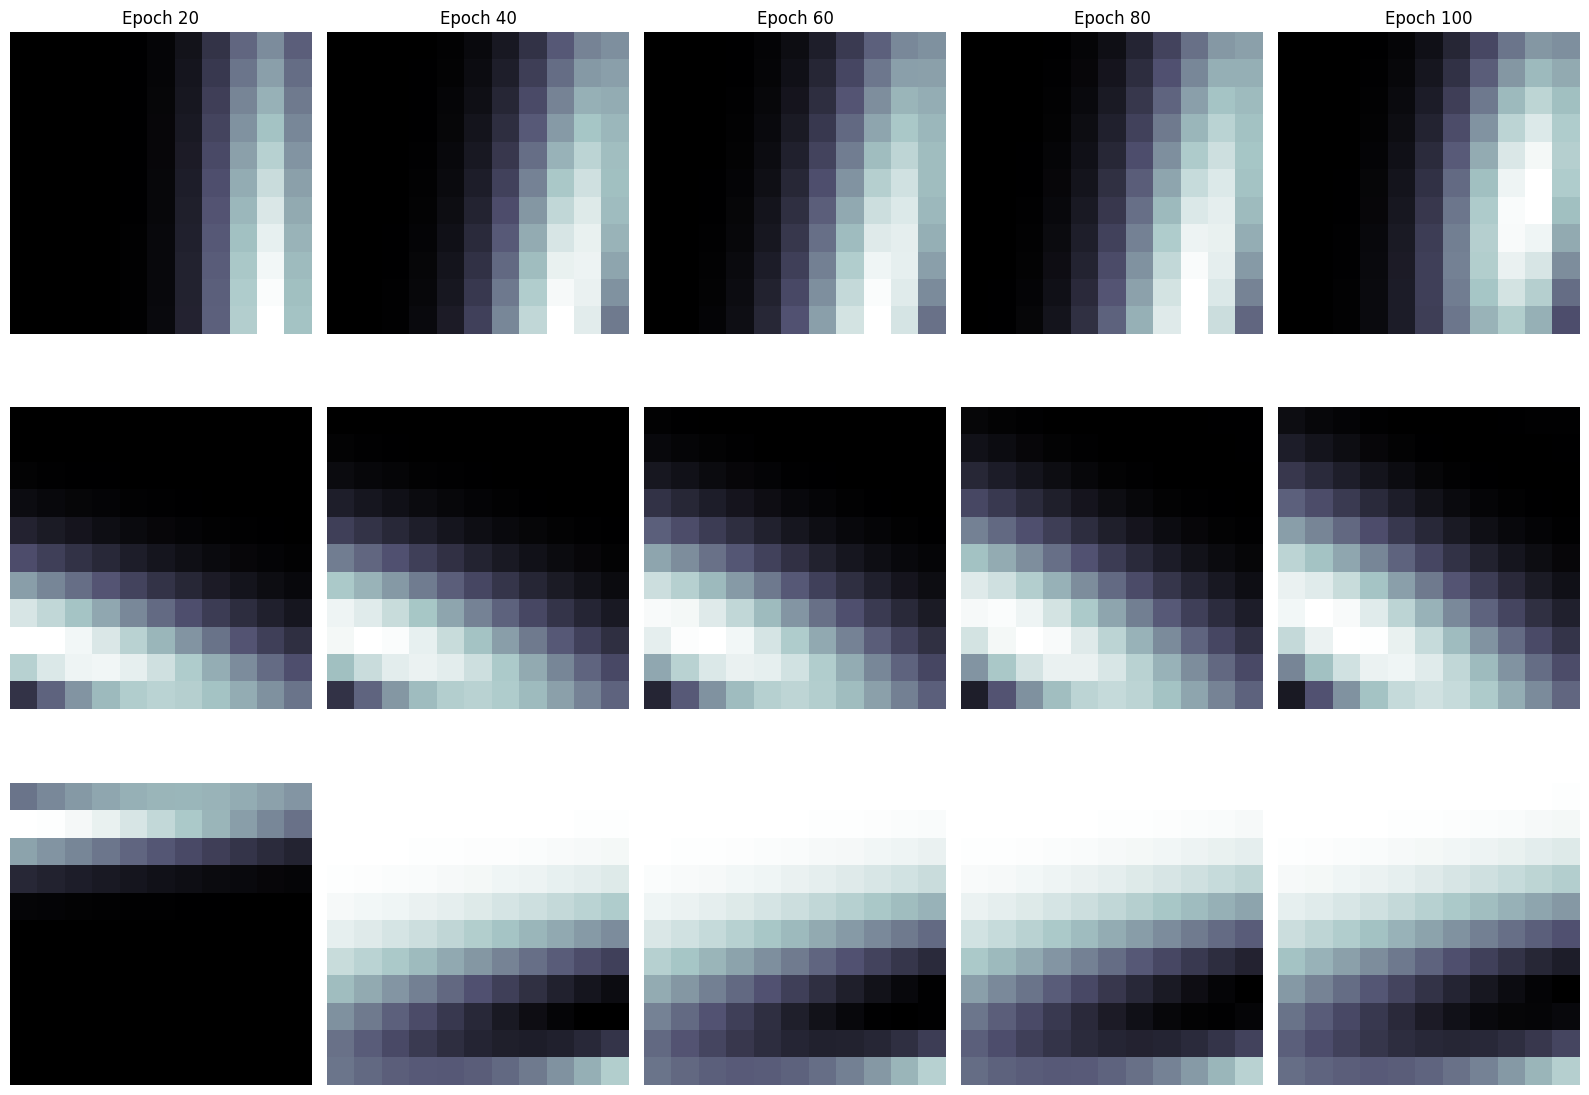

In [ ]:
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_blurry_to_clear_100_epochs"
model = AlexNetSup(num_classes=12).to(device)

selected_rf = visualize_receptive_fields(model, model_dir, device)

with open(os.path.join(output_dir, "toybox12_receptive_fields.pkl"), "wb") as f:
    pickle.dump(selected_rf, f)

plot_gabor_receptive_fields(selected_rf)

### Toybox 360 blurry-to-clear training

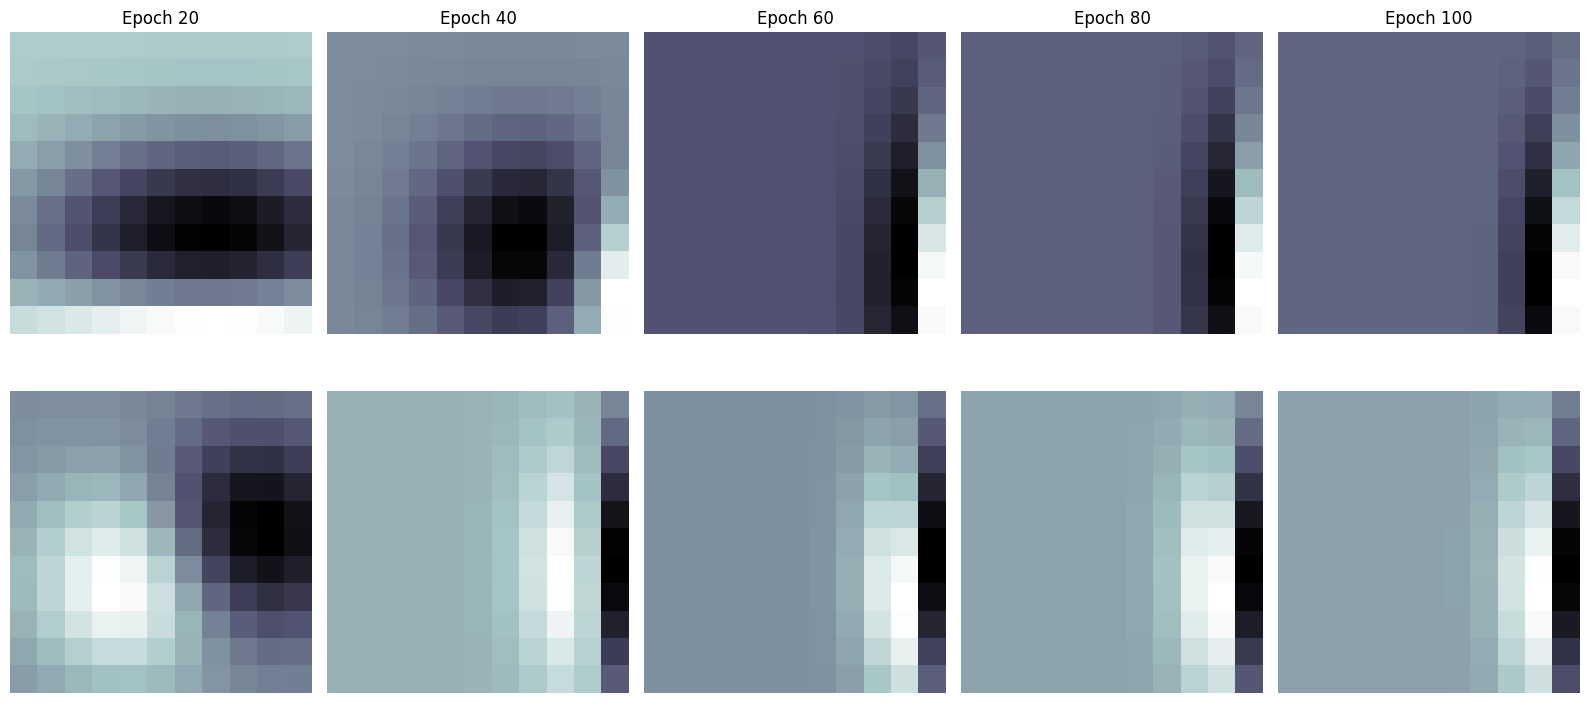

In [ ]:
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_blur_100_epochs"
model = AlexNetSup(num_classes=360).to(device)

selected_rf = visualize_receptive_fields(model, model_dir, device)

with open(os.path.join(output_dir, "toybox360_receptive_fields.pkl"), "wb") as f:
    pickle.dump(selected_rf, f)

plot_gabor_receptive_fields(selected_rf)

### FaceScrub clear-to-blur training

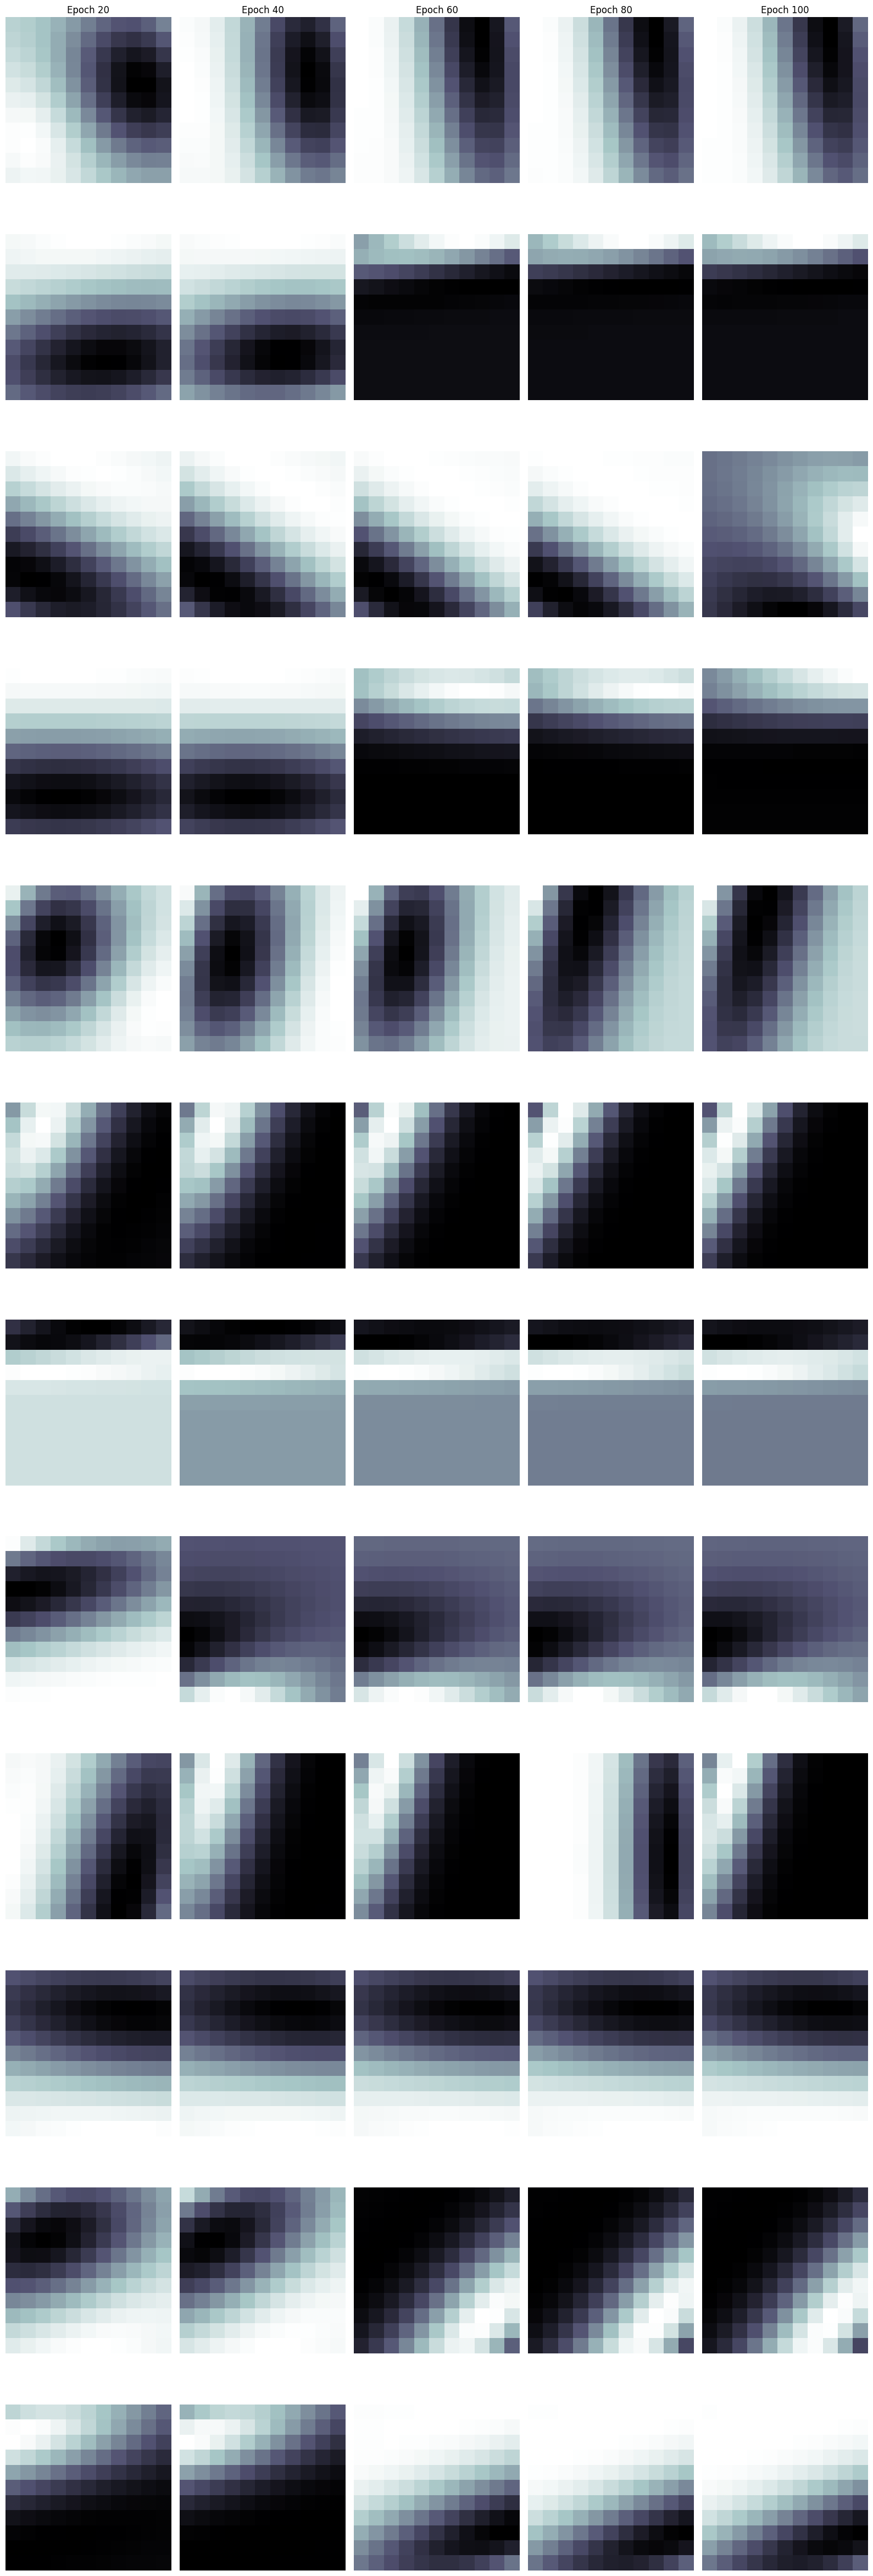

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/facescrub_blur_100_epochs"
model = AlexNetSup(num_classes=297).to(device)

selected_rf = visualize_receptive_fields(model, model_dir, device)

with open(os.path.join(output_dir, "facescrub_receptive_fields.pkl"), "wb") as f:
    pickle.dump(selected_rf, f)

plot_gabor_receptive_fields(selected_rf)

### ImageNet-12 clear-to-blur training

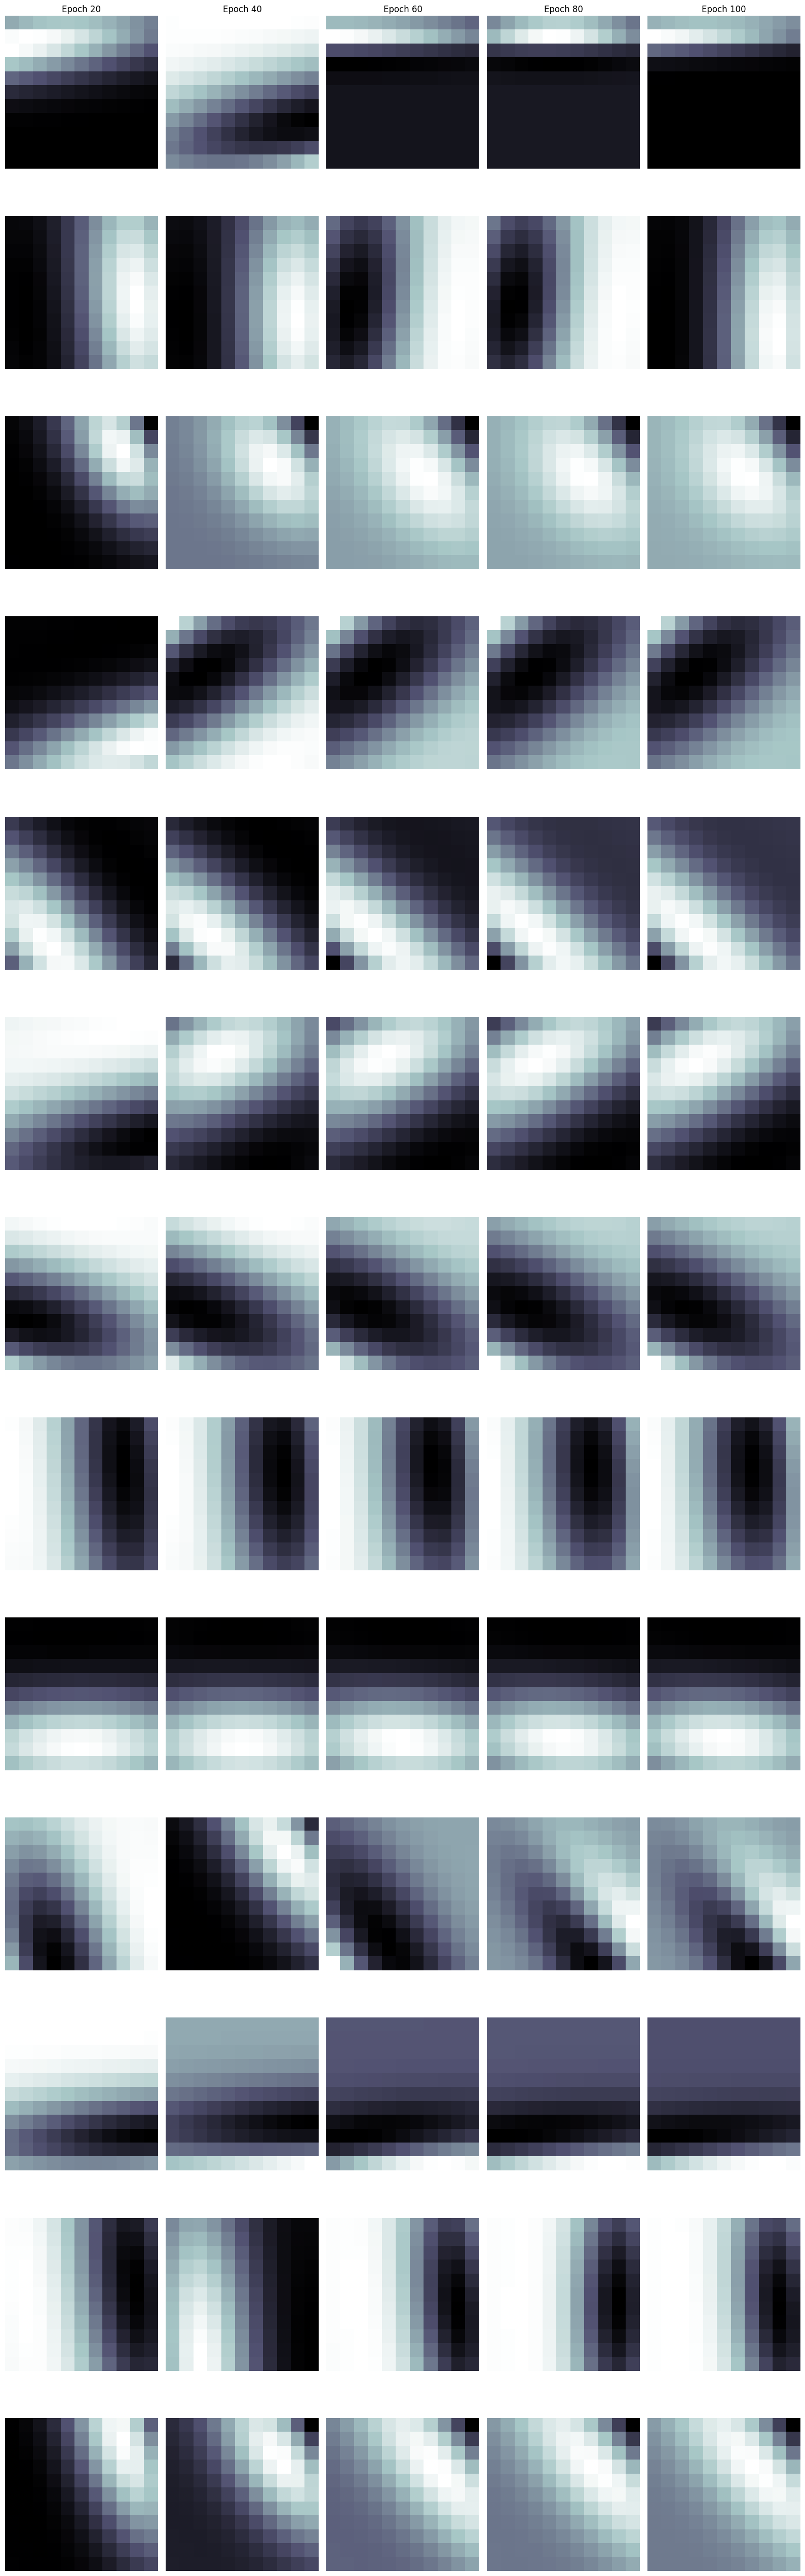

In [ ]:
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN12_blurry_to_clear_100_epochs"
model = AlexNetSup(num_classes=12).to(device)

selected_rf = visualize_receptive_fields(model, model_dir, device)

with open(os.path.join(output_dir, "IN12_receptive_fields.pkl"), "wb") as f:
    pickle.dump(selected_rf, f)

plot_gabor_receptive_fields(selected_rf)

### ImageNet-100 clear-to-blur training

<ipython-input-3-f14f34d3716d>:72: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_residual / ss_total)


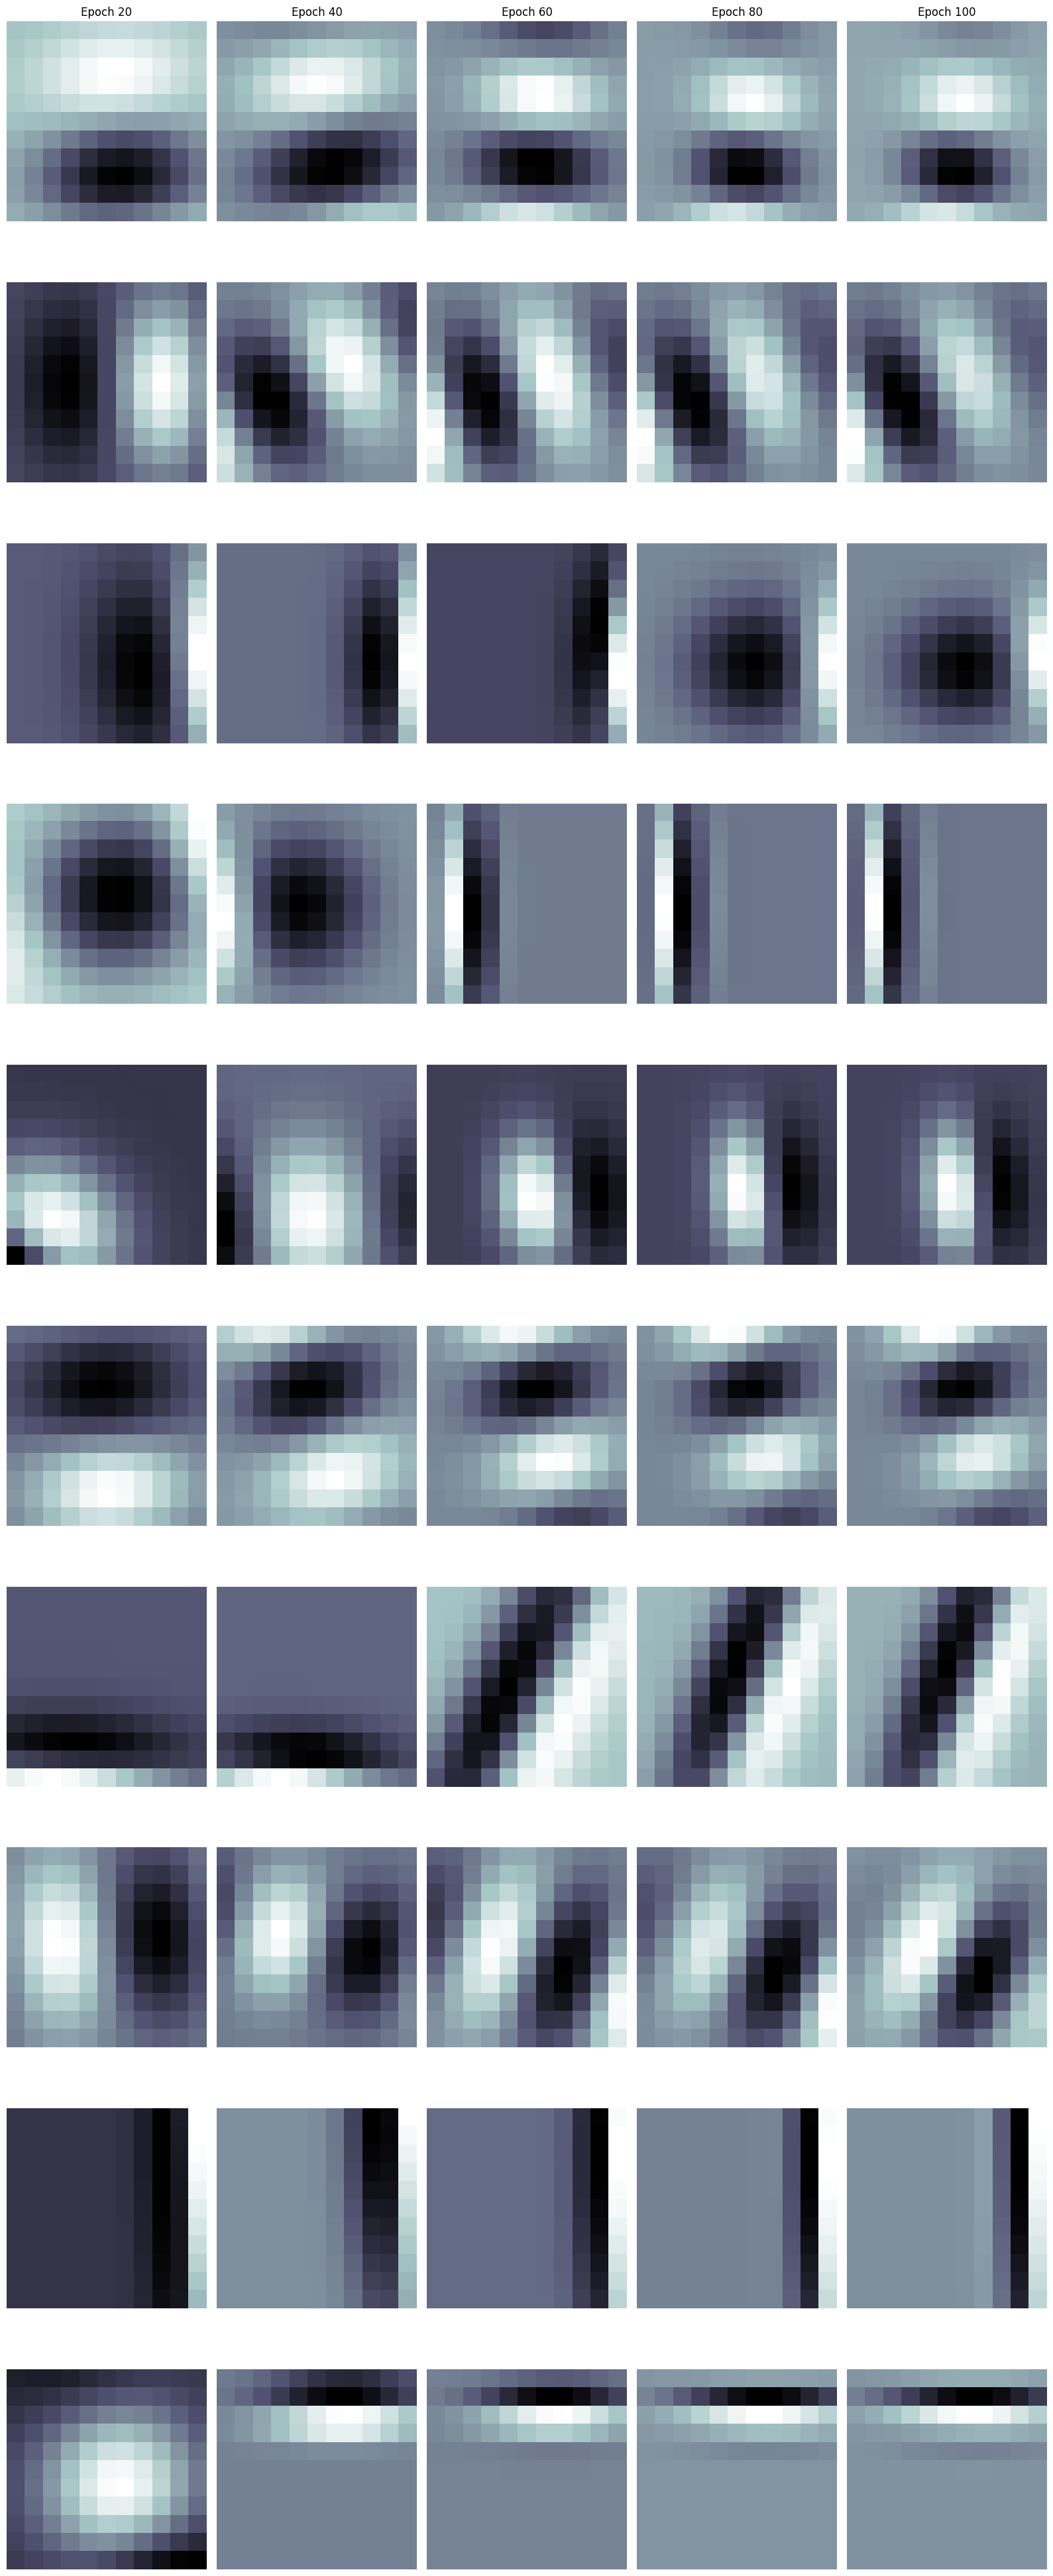

In [ ]:
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_blur"
model = AlexNetSup(num_classes=100).to(device)

selected_rf = visualize_receptive_fields(model, model_dir, device)

with open(os.path.join(output_dir, "IN100_receptive_fields.pkl"), "wb") as f:
    pickle.dump(selected_rf, f)

plot_gabor_receptive_fields(selected_rf)

## Receptive field size

In [ ]:
def compute_avg_sigmas(selected_rf):
    """
    Compute average receptive field size (using sigma_x) for filters that have valid fits
    (non-None) across all epochs.
    """
    epochs = sorted(selected_rf.keys())
    # Identify filter indices that have valid fits across all epochs
    first_epoch = epochs[0]
    num_filters = len(selected_rf[first_epoch])
    common_valid_indices = []
    for i in range(num_filters):
        if all(selected_rf[epoch][i] is not None for epoch in epochs):
            common_valid_indices.append(i)

    if not common_valid_indices:
        print("No filter has a valid fit across all epochs.")
        return {}

    rf_sizes = {}
    for epoch in epochs:
        # Average sigma_x for only the filters that have valid fits across all epochs
        sigmas = [selected_rf[epoch][i][3] for i in common_valid_indices]
        rf_sizes[epoch] = np.mean(sigmas)
    return rf_sizes

def compute_avg_sigmas(selected_rf):
    """
    Compute average receptive field size (using sigma_x) for each epoch by averaging over
    all filters that have a valid (non-None) fit at that epoch.

    This method avoids the bias introduced by only considering filters that are valid across
    all epochs.
    """
    rf_sizes = {}
    for epoch in sorted(selected_rf.keys()):
        valid_fits = [rf for rf in selected_rf[epoch] if rf is not None]
        count = len(valid_fits)
        print(f"Epoch {epoch}, count: {count}")
        if count > 0:
            # Extract sigma_x (assumed to be the 4th parameter) from each valid fit
            sigmas = [rf[3] for rf in valid_fits]
            rf_sizes[epoch] = np.mean(sigmas)
        else:
            rf_sizes[epoch] = None  # Or handle the case as you prefer
    return rf_sizes

In [ ]:
def compute_avg_sigmas(selected_rf):
    """
    Compute the average sigma_x over time using only filters with a complete history across epochs.

    For each filter with a valid fit (non-None) for every epoch, extract its sigma_x trajectory.
    Then, for each epoch, compute the mean sigma_x across these filters.

    This function prints the count of filters with a complete history and returns a dictionary
    mapping each epoch to the average sigma_x.

    Parameters:
        selected_rf (dict): A dictionary mapping each epoch to a list of filter fits (or None).

    Returns:
        dict: A dictionary where each key is an epoch and the value is the average sigma_x for that epoch.
    """
    epochs = sorted(selected_rf.keys())
    num_filters = len(selected_rf[epochs[0]])

    # Identify filter indices with a complete valid history across all epochs.
    complete_indices = [
        i for i in range(num_filters) if all(selected_rf[epoch][i] is not None for epoch in epochs)
    ]

    if not complete_indices:
        print("No filter has a complete history across epochs.")
        return {}

    # Print the count of filters with complete history
    count = len(complete_indices)
    print(f"Number of filters with complete history: {count}")

    # Compute average sigma_x for each epoch using only the filters with complete history
    rf_sizes = {}
    for epoch in epochs:
        sigma_values = [selected_rf[epoch][i][3] for i in complete_indices]
        print(f"Epoch {epoch}, sigma values: {sigma_values}")
        sigma_values = [v for v in sigma_values if v is not None and 0 < v < 20]

        if sigma_values:
            rf_sizes[epoch] = np.median(sigma_values)
        else:
            rf_sizes[epoch] = None
    return rf_sizes


def plot_rf_size_evolution(epochs, Toybox12_sigmas, Toybox360_sigmas, FaceScrub_sigmas, IN12_sigmas, IN100_sigmas):
    """
    Plot the evolution of receptive field sizes across datasets.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, Toybox12_sigmas, marker='o', color="#a00000", label="Toybox category-level")
    plt.plot(epochs, Toybox360_sigmas, marker='o', color='#1f6f6f', label="Toybox instance-level")
    plt.plot(epochs, FaceScrub_sigmas, marker='o', color='#57039c', label="Faces")
    plt.plot(epochs, IN12_sigmas, marker='o', color='#082a54', label="ImageNet-12")
    plt.plot(epochs, IN100_sigmas, marker='o', color='#f5d76e', label="ImageNet-100")

    plt.xlabel("Epoch")
    plt.ylabel("Receptive Field Size (σ)")
    plt.title("Evolution of Receptive Field Size")
    plt.legend()

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

Toybox (category):
Epoch 10, count: 0
Epoch 20, count: 3
Epoch 30, count: 5
Epoch 40, count: 5
Epoch 50, count: 7
Epoch 60, count: 9
Epoch 70, count: 12
Epoch 80, count: 13
Epoch 90, count: 13
Epoch 100, count: 14
Toybox (instances):
Epoch 10, count: 12
Epoch 20, count: 20
Epoch 30, count: 22
Epoch 40, count: 22
Epoch 50, count: 13
Epoch 60, count: 16
Epoch 70, count: 15
Epoch 80, count: 14
Epoch 90, count: 10
Epoch 100, count: 9
Faces:
Epoch 10, count: 24
Epoch 20, count: 26
Epoch 30, count: 19
Epoch 40, count: 18
Epoch 50, count: 18
Epoch 60, count: 19
Epoch 70, count: 16
Epoch 80, count: 16
Epoch 90, count: 15
Epoch 100, count: 15
ImageNet-12:
Epoch 10, count: 14
Epoch 20, count: 20
Epoch 30, count: 13
Epoch 40, count: 17
Epoch 50, count: 15
Epoch 60, count: 18
Epoch 70, count: 15
Epoch 80, count: 15
Epoch 90, count: 17
Epoch 100, count: 17
ImageNet-100:
Epoch 10, count: 25
Epoch 20, count: 25
Epoch 30, count: 19
Epoch 40, count: 16
Epoch 50, count: 14
Epoch 60, count: 17
Epoch 70, 

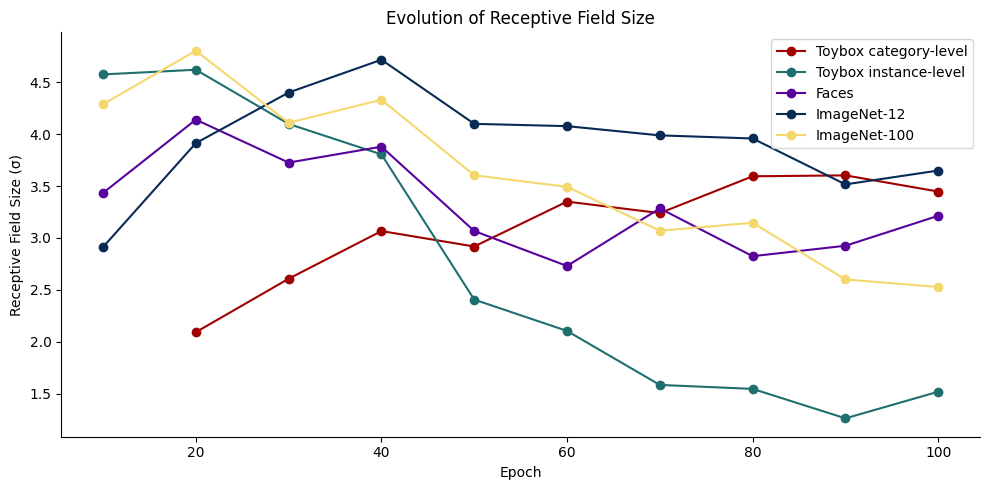

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

output_dir = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/receptive_fields"

#Load toybox (category) values
print("Toybox (category):")
with open(os.path.join(output_dir, "toybox12_receptive_fields.pkl"), "rb") as f:
    selected_rf = pickle.load(f)
sigma_values = compute_avg_sigmas(selected_rf)
toybox12_sigmas = [sigma_values[k] for k in sorted(sigma_values)]

print("Toybox (instances):")
#Load toybox (instances) values
with open(os.path.join(output_dir, "toybox360_receptive_fields.pkl"), "rb") as f:
    selected_rf = pickle.load(f)
sigma_values = compute_avg_sigmas(selected_rf)
toybox360_sigmas = [sigma_values[k] for k in sorted(sigma_values)]

print("Faces:")
#Load face values
with open(os.path.join(output_dir, "facescrub_receptive_fields.pkl"), "rb") as f:
    selected_rf = pickle.load(f)
sigma_values = compute_avg_sigmas(selected_rf)
facescrub_sigmas = [sigma_values[k] for k in sorted(sigma_values)]

print("ImageNet-12:")
#Load IN12 values
with open(os.path.join(output_dir, "IN12_receptive_fields.pkl"), "rb") as f:
    selected_rf = pickle.load(f)
sigma_values = compute_avg_sigmas(selected_rf)
IN12_sigmas = [sigma_values[k] for k in sorted(sigma_values)]

print("ImageNet-100:")
#Load IN100 values
with open(os.path.join(output_dir, "IN100_receptive_fields.pkl"), "rb") as f:
    selected_rf = pickle.load(f)
sigma_values = compute_avg_sigmas(selected_rf)
IN100_sigmas = [sigma_values[k] for k in sorted(sigma_values)]

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plot_rf_size_evolution(epochs, toybox12_sigmas, toybox360_sigmas, facescrub_sigmas, IN12_sigmas, IN100_sigmas)

## Just extracting kernel

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_kernel_evolution(model_dir, num_classes):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    epochs = [20, 40, 60, 80, 100]
    evolution = []

    for epoch in epochs:
        model = AlexNetSup(num_classes=num_classes).to(device)
        checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        if isinstance(checkpoint, dict):
            if "backbone" in checkpoint:
                model.backbone.model.load_state_dict(checkpoint["backbone"])
            elif "state_dict" in checkpoint:
                model.load_state_dict(checkpoint["state_dict"])
            elif "model_state_dict" in checkpoint:
                model.load_state_dict(checkpoint["model_state_dict"])
            else:
                model.load_state_dict(checkpoint)
        else:
            model.load_state_dict(checkpoint)

        kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()
        # Convert to grayscale
        if kernels.shape[1] > 1:
            kernels = np.mean(kernels, axis=1)
        else:
            kernels = kernels.squeeze(1)

        first10 = kernels[:10]
        evolution.append(first10)

    fig, axes = plt.subplots(10, 5, figsize=(10, 20))

    for row in range(10):
        for col, epoch in enumerate(epochs):
            ax = axes[row, col]
            kernel = evolution[col][row]
            # Normalize kernel values for better contrast
            kernel_norm = (kernel - kernel.min()) / (kernel.max() - kernel.min())
            ax.imshow(kernel_norm, cmap='bone')
            ax.axis('off')
            # Optionally, set a title at the top row for the epoch
            if row == 0:
                ax.set_title(f"Epoch {epoch}", fontsize=12)
            # Optionally, label the rows (kernel index) on the left-most column
            if col == 0:
                ax.set_ylabel(f"Kernel {row+1}", rotation=90, fontsize=10, labelpad=5)

    plt.tight_layout()
    plt.show()

### Toybox (category)

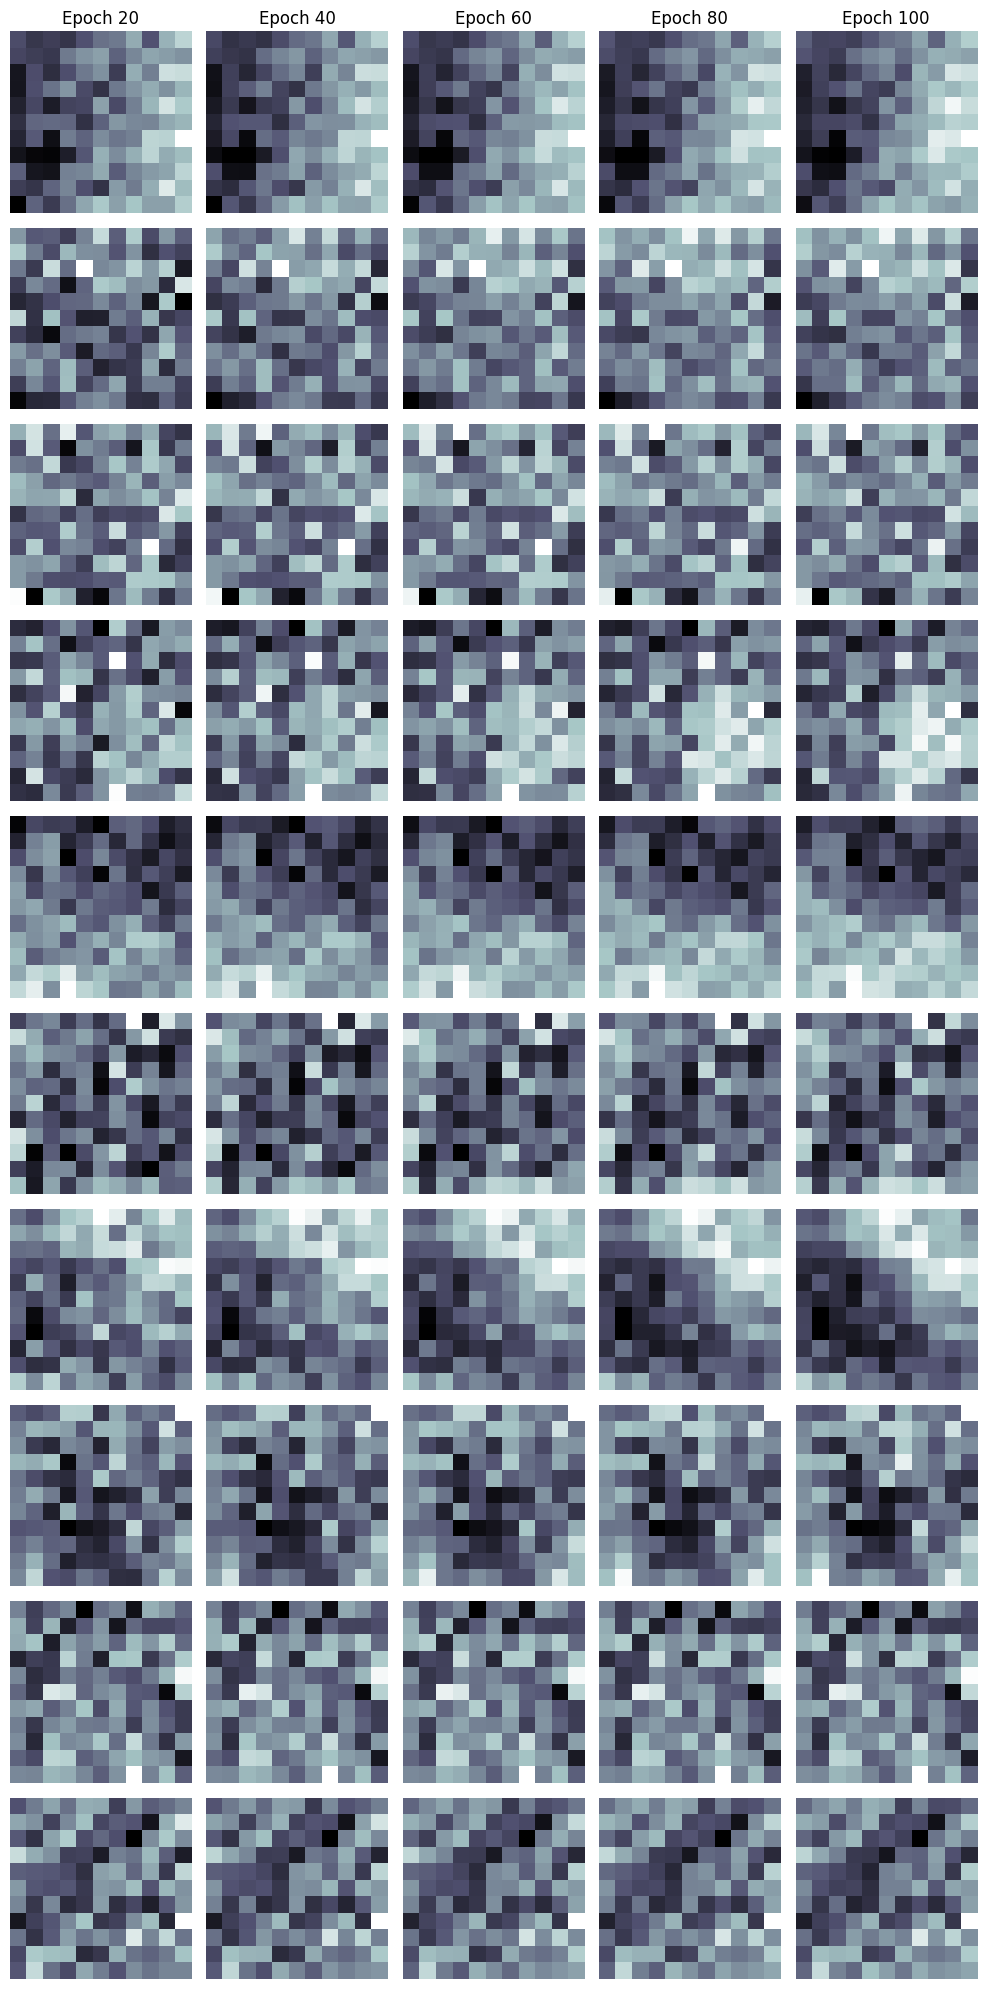

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_blurry_to_clear_100_epochs"

plot_kernel_evolution(model_dir, 12)

### Toybox (instances)

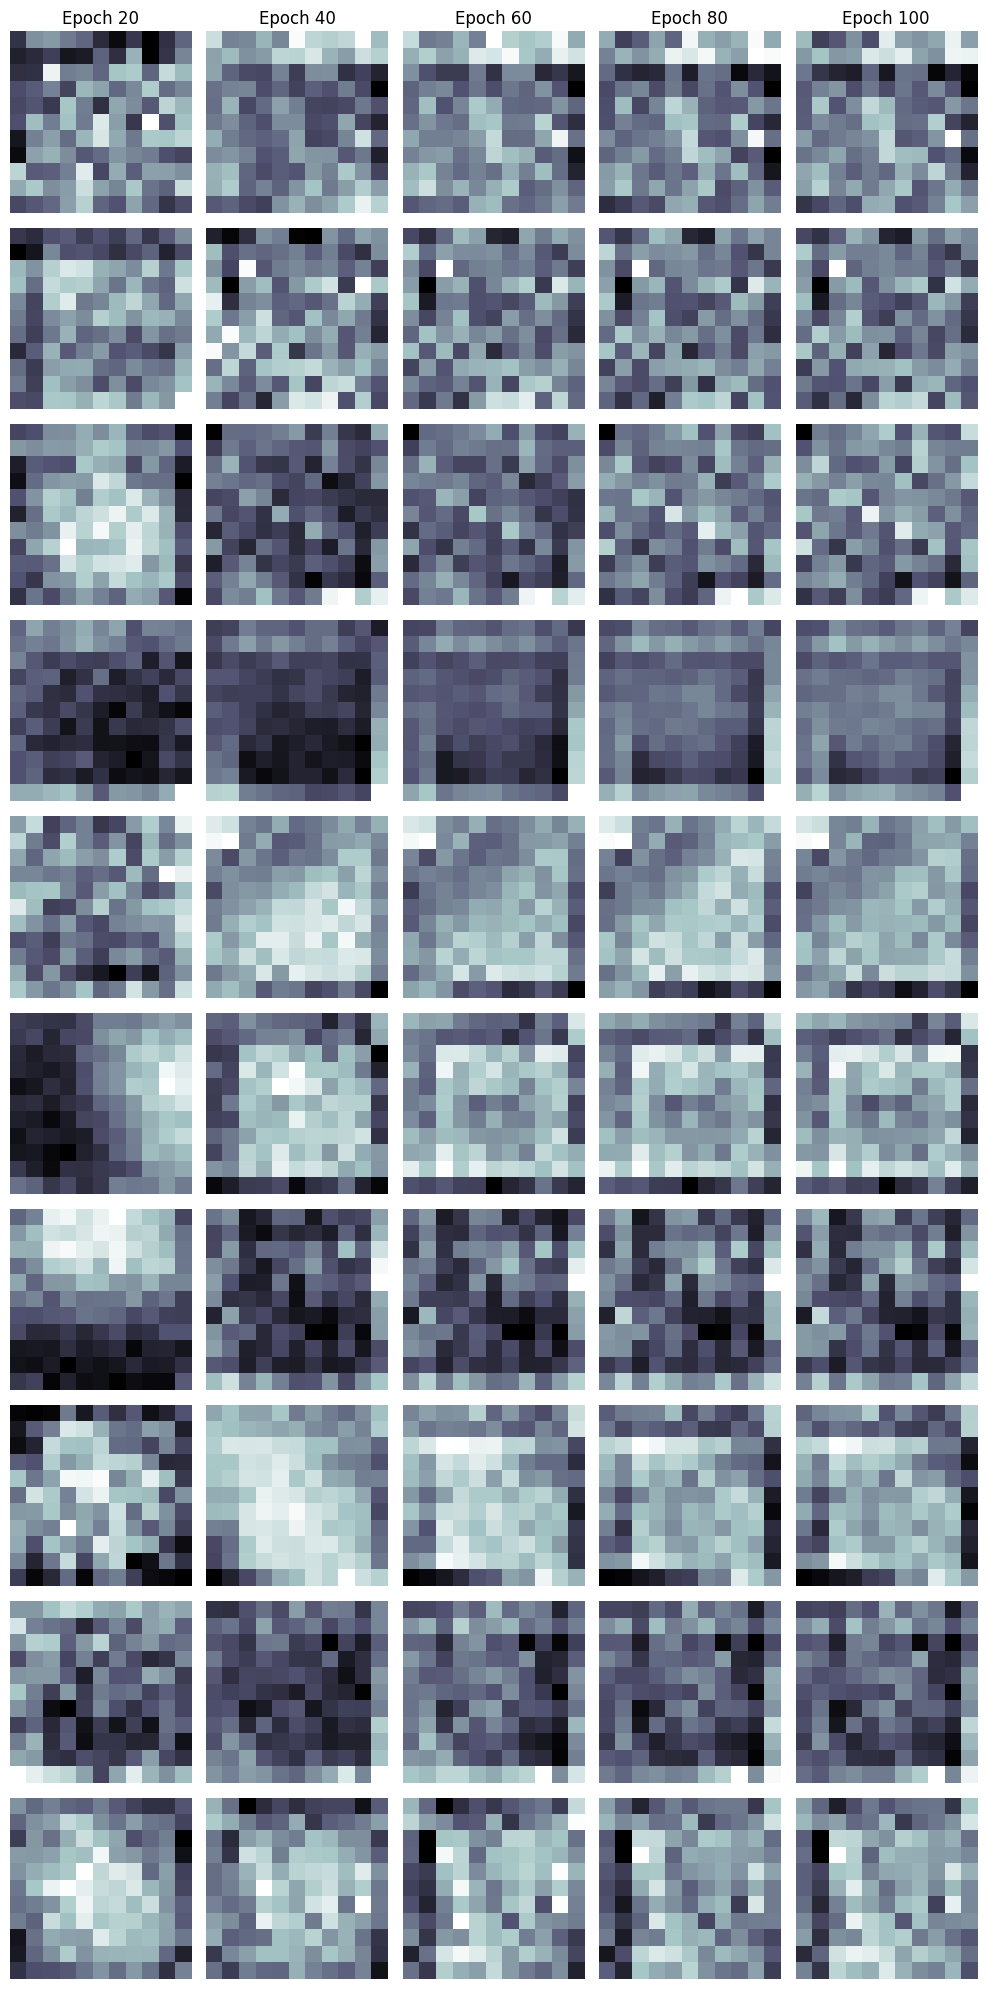

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_blur_100_epochs"

plot_kernel_evolution(model_dir, 360)

### Faces

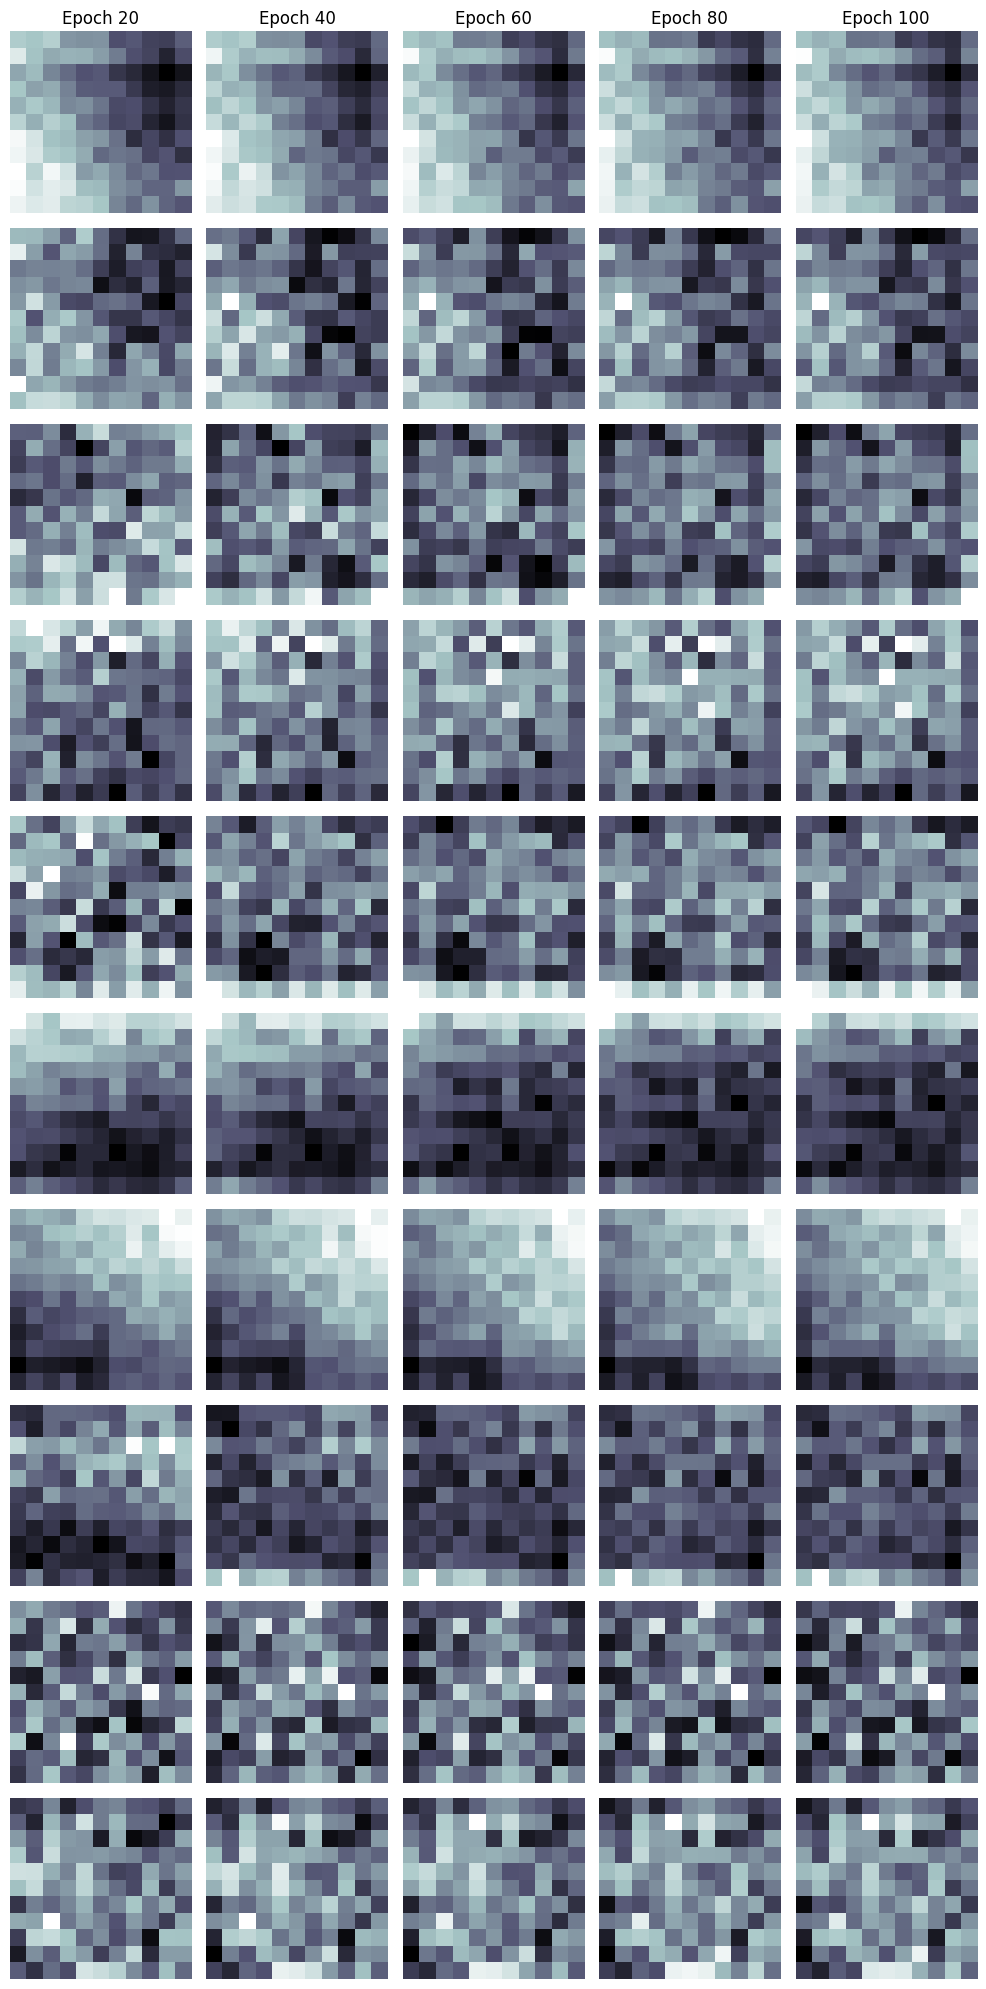

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/facescrub_blur_100_epochs"

plot_kernel_evolution(model_dir, 297)

### ImageNet-12

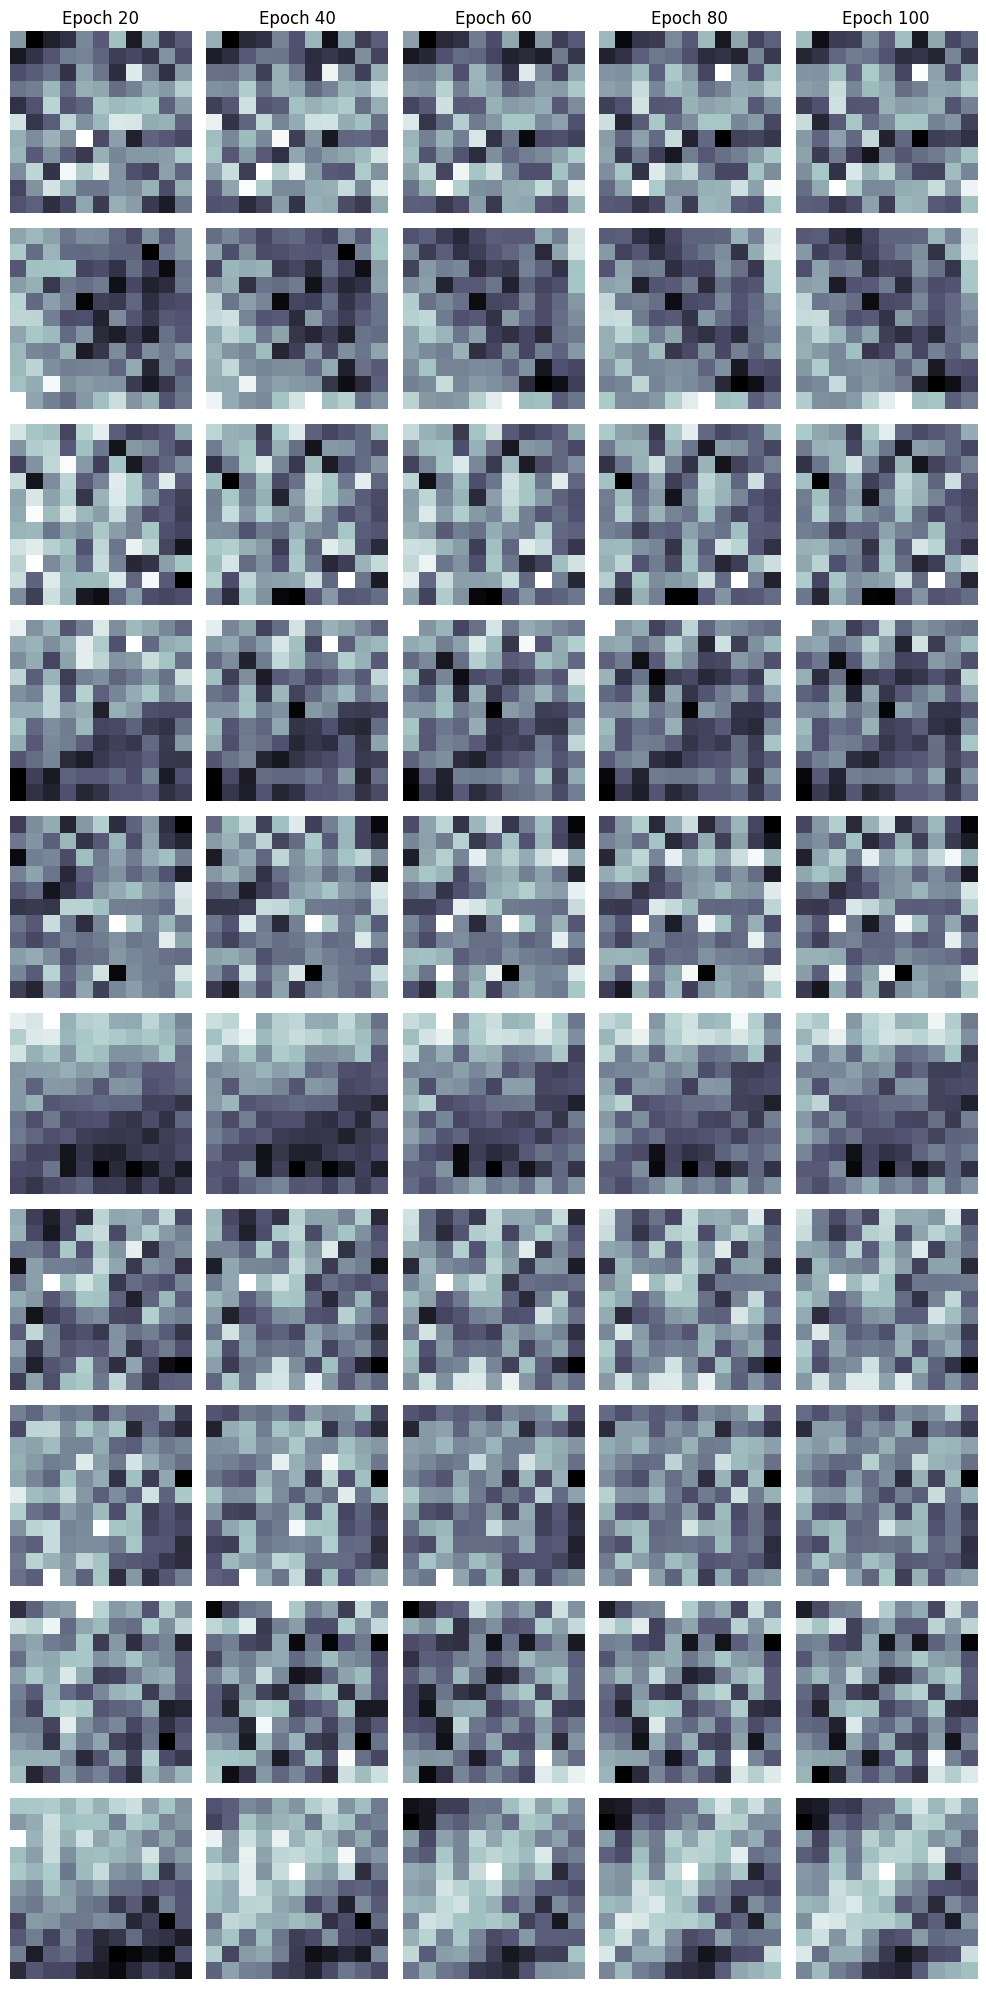

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN12_blurry_to_clear_100_epochs"
plot_kernel_evolution(model_dir, 12)

### ImageNet-100

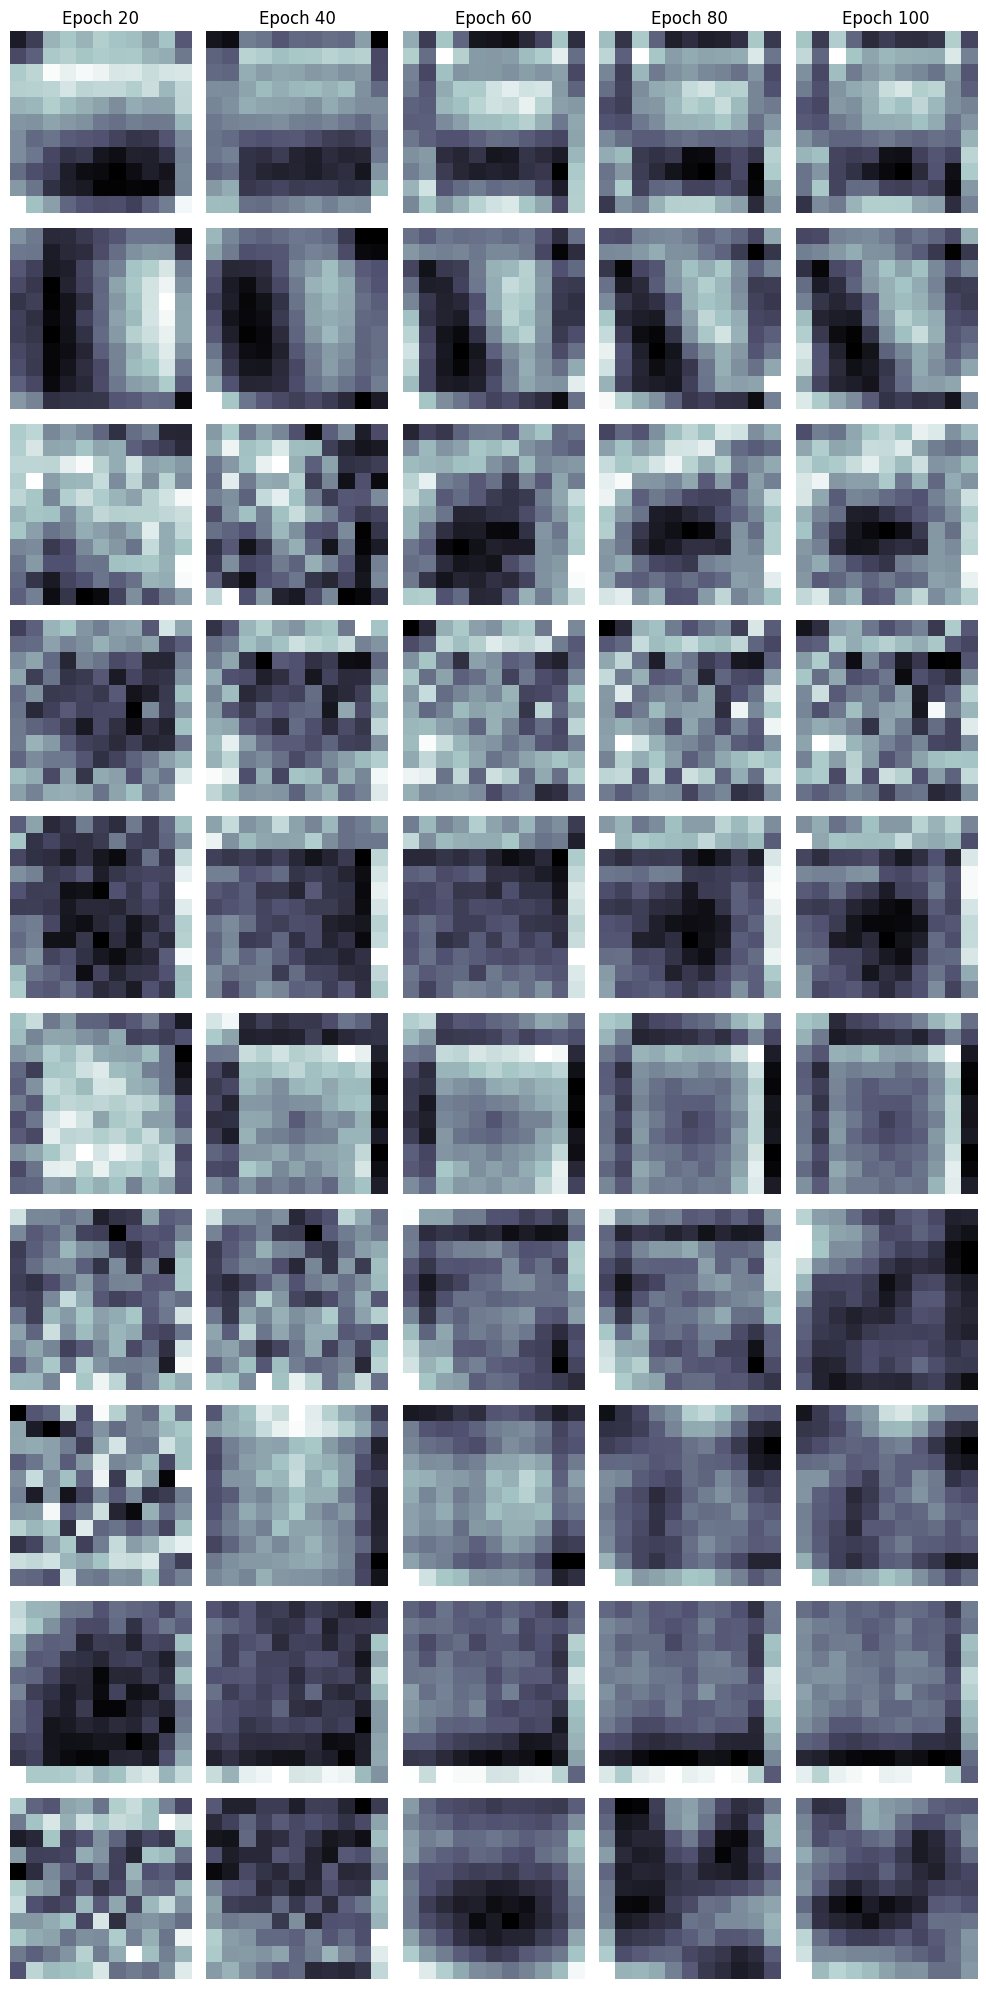

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_blur"
plot_kernel_evolution(model_dir, 100)

## Quantify receptive field size (Gabor)

In [ ]:
import os
import torch
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from model import AlexNetSup

# Assuming you already have the gabor_2d and fit_gabor functions defined as in your original code.
def gabor_2d(xy, A, x0, y0, sigma_x, sigma_y, theta, freq, phase, offset):
    """2D Gabor function."""
    x, y = xy
    x_rot = (x - x0) * np.cos(theta) + (y - y0) * np.sin(theta)
    y_rot = -(x - x0) * np.sin(theta) + (y - y0) * np.cos(theta)
    gaussian = np.exp(-((x_rot ** 2) / (2 * sigma_x ** 2) + (y_rot ** 2) / (2 * sigma_y ** 2)))
    sinusoid = np.cos(2 * np.pi * freq * x_rot + phase)
    return A * gaussian * sinusoid + offset

def fit_gabor(filter):
    """Fit a 2D elliptical Gabor function to a receptive field filter."""
    h, w = filter.shape
    y, x = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    xdata = np.vstack((x.ravel(), y.ravel()))
    ydata = filter.ravel()

    def loss(params):
        return np.sum((gabor_2d(xdata, *params) - ydata) ** 2)

    best_params = None
    best_loss = np.inf

    # Parameter bounds: (A, x0, y0, sigma_x, sigma_y, theta, frequency, phase, offset)
    bounds = [
        (0.1, 5.0),        # Amplitude (A)
        (0, w),            # Center x0
        (0, h),            # Center y0
        (1.0, 10.0),       # Sigma_x
        (1.0, 10.0),       # Sigma_y
        (0, np.pi),        # Theta
        (0.05, 0.5),       # Frequency
        (0, 2 * np.pi),    # Phase
        (None, None)       # Offset (unbounded)
    ]

    # Sample 100 different starting points for optimization.
    for _ in range(100):
        init_params = [
            np.random.uniform(0.5, 2.0),   # Amplitude (A)
            w // 2,                      # Center x0
            h // 2,                      # Center y0
            np.random.uniform(1.0, 5.0),   # Sigma_x
            np.random.uniform(1.0, 5.0),   # Sigma_y
            np.random.uniform(0, np.pi),   # Theta
            np.random.uniform(0.05, 0.5),  # Frequency
            np.random.uniform(0, 2 * np.pi),  # Phase
            np.mean(ydata)               # Offset
        ]
        res = opt.minimize(loss, init_params, method='L-BFGS-B', bounds=bounds)
        if res.success and res.fun < best_loss:
            best_loss = res.fun
            best_params = res.x

    if best_params is None:
        return None, 0  # No valid fit

    # Calculate R-squared value.
    fitted = gabor_2d(xdata, *best_params).reshape(h, w)
    ss_total = np.sum((ydata - np.mean(ydata)) ** 2)
    ss_residual = np.sum((ydata - fitted.ravel()) ** 2)
    r_squared = 1 - (ss_residual / ss_total)

    return best_params, r_squared

def quantify_receptive_field_sizes(model, device):
    """
    Quantify receptive field sizes of the first convolutional layer.

    For each filter in the first conv layer, fit a 2D elliptical Gabor function.
    Filters with R-squared values less than 0.4 are excluded.
    The receptive field size is defined as the average of sigma_x and sigma_y.

    Returns:
        sizes: A list where each element is the RF size (or None if the fit was invalid).
        valid_sizes: A list of sizes for filters that passed the R-squared threshold.
    """
    # Extract the weights from the first convolutional layer.
    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()  # shape: (num_filters, channels, H, W)

    # Convert to grayscale if necessary.
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    sizes = []
    valid_sizes = []

    # Fit each kernel and compute the receptive field size.
    for idx, kernel in enumerate(kernels):
        params, r_squared = fit_gabor(kernel)
        if params is not None and r_squared >= 0.4:
            sigma_x = params[3]
            sigma_y = params[4]
            # The size is defined as the average of the two standard deviations.
            rf_size = (sigma_x + sigma_y) / 2.0
            sizes.append(rf_size)
            valid_sizes.append(rf_size)
            print(f"Filter {idx}: RF size = {rf_size:.2f} (R² = {r_squared:.2f})")
        else:
            sizes.append(None)
            print(f"Filter {idx}: Invalid fit (R² = {r_squared:.2f})")

    return sizes, valid_sizes

def load_model_from_checkpoint(checkpoint_path, num_classes, device):
    model = AlexNetSup(num_classes=num_classes).to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if isinstance(checkpoint, dict):
        if "backbone" in checkpoint:
            model.backbone.model.load_state_dict(checkpoint["backbone"])
        elif "state_dict" in checkpoint:
            model.load_state_dict(checkpoint["state_dict"])
        elif "model_state_dict" in checkpoint:
            model.load_state_dict(checkpoint["model_state_dict"])
        else:
            model.load_state_dict(checkpoint)
    else:
        model.load_state_dict(checkpoint)
    return model

## Quantify receptive field size (moments)

In [14]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from model import AlexNetSup

def load_model_from_checkpoint(checkpoint_path, num_classes, device):
    model = AlexNetSup(num_classes=num_classes).to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if isinstance(checkpoint, dict):
        if "backbone" in checkpoint:
            model.backbone.model.load_state_dict(checkpoint["backbone"])
        elif "state_dict" in checkpoint:
            model.load_state_dict(checkpoint["state_dict"])
        elif "model_state_dict" in checkpoint:
            model.load_state_dict(checkpoint["model_state_dict"])
        else:
            model.load_state_dict(checkpoint)
    else:
        model.load_state_dict(checkpoint)
    return model

def compute_rf_size_moments(kernel):
    """
    Compute the receptive field size based on the spatial moments of the kernel.

    This function assumes the kernel is a 2D array (e.g., 11x11).
    It computes the center of mass and the standard deviations (σₓ, σᵧ)
    of the absolute values of the kernel, and returns their average.
    """
    abs_kernel = np.abs(kernel)

    total = np.sum(abs_kernel)
    if total == 0:
        return 0
    norm_kernel = abs_kernel / total

    h, w = kernel.shape
    y, x = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')

    x_center = np.sum(x * norm_kernel)
    y_center = np.sum(y * norm_kernel)

    sigma_x = np.sqrt(np.sum(norm_kernel * (x - x_center) ** 2))
    sigma_y = np.sqrt(np.sum(norm_kernel * (y - y_center) ** 2))

    return sigma_x + sigma_y

def plot_kernel_evolution(model_dir, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epochs = [20, 40, 60, 80, 100]
    evolution = []

    for epoch in epochs:
        model = AlexNetSup(num_classes=num_classes).to(device)
        checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        if isinstance(checkpoint, dict):
            if "backbone" in checkpoint:
                model.backbone.model.load_state_dict(checkpoint["backbone"])
            elif "state_dict" in checkpoint:
                model.load_state_dict(checkpoint["state_dict"])
            elif "model_state_dict" in checkpoint:
                model.load_state_dict(checkpoint["model_state_dict"])
            else:
                model.load_state_dict(checkpoint)
        else:
            model.load_state_dict(checkpoint)

        kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()
        if kernels.shape[1] > 1:
            kernels = np.mean(kernels, axis=1)
        else:
            kernels = kernels.squeeze(1)

        evolution.append(kernels)

    num_filters = evolution[0].shape[0]

    # Compute the average absolute weight for each filter using the final epoch's kernel.
    weight_values = []
    for i in range(num_filters):
        weight_val = np.mean(np.abs(evolution[-1][i]))
        weight_values.append((i, weight_val))

    # Sort filters by the weight metric (largest first) and select the top 10.
    top_filters = sorted(weight_values, key=lambda x: x[1], reverse=True)[:10]

    fig, axes = plt.subplots(10, len(epochs), figsize=(10, 20))

    for row, (filter_index, weight_val) in enumerate(top_filters):
        for col, epoch in enumerate(epochs):
            ax = axes[row, col]
            kernel = evolution[col][filter_index]
            kernel_norm = (kernel - kernel.min()) / (kernel.max() - kernel.min())
            ax.imshow(kernel_norm, cmap='gray')
            ax.axis('off')
            if row == 0:
                ax.set_title(f"Epoch {epoch}", fontsize=12)
            if col == 0:
                ax.set_ylabel(f"Filter {filter_index}\nWeight = {weight_val:.2f}",
                              rotation=90, fontsize=10, labelpad=5)

    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import numpy as np
import torch
import os

def plot_first_layer_kernels(model_dir, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AlexNetSup(num_classes=num_classes).to(device)
    checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch100.pth")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    if isinstance(checkpoint, dict):
        if "backbone" in checkpoint:
            model.backbone.model.load_state_dict(checkpoint["backbone"])
        elif "state_dict" in checkpoint:
            model.load_state_dict(checkpoint["state_dict"])
        elif "model_state_dict" in checkpoint:
            model.load_state_dict(checkpoint["model_state_dict"])
        else:
            model.load_state_dict(checkpoint)
    else:
        model.load_state_dict(checkpoint)

    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    num_kernels = kernels.shape[0]
    num_cols = 8
    num_rows = (num_kernels + num_cols - 1) // num_cols  # ensure all kernels are shown

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))
    axes = axes.flatten()

    abs_vals = []

    for i in range(num_kernels):
        kernel = kernels[i]
        kernel = (kernel - kernel.min()) / (kernel.max() - kernel.min() + 1e-6)
        axes[i].imshow(kernel, cmap='gray')
        axes[i].axis('off')

        abs_val = np.mean(np.abs(kernel))
        abs_vals.append(abs_val)
        #print(f"Kernel {i}: {abs_val:.4f}")

        axes[i].text(0.5, 0.9, f'{abs_val:.2f}', transform=axes[i].transAxes,
                     ha='center', va='center', color='red', fontsize=8,
                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Hide unused subplots
    for j in range(num_kernels, len(axes)):
        axes[j].axis('off')

    mean_val = np.mean(abs_vals)
    std_val = np.std(abs_vals)
    print(f"\nMean of abs values: {mean_val:.4f}")
    print(f"Standard deviation: {std_val:.4f}")

    plt.tight_layout()
    plt.show()

### Toybox (category)

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_blurry_to_clear_100_epochs"
checkpoint_epoch = 100
checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{checkpoint_epoch}.pth")

num_classes = 12

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model_from_checkpoint(checkpoint_path, num_classes, device)

# Quantify the receptive field sizes.
toybox12_all_sizes, toybox12_valid_sizes = quantify_receptive_field_sizes(model, device)

if toybox12_valid_sizes:
    toybox12_avg_rf_size = np.mean(toybox12_valid_sizes)
    print(f"\nAverage receptive field size (over {len(toybox12_valid_sizes)} valid filters): {toybox12_avg_rf_size:.2f}")
else:
    print("No filters passed the R-squared threshold for a valid fit.")

Filter 0: RF size = 4.39 (R² = 0.72)
Filter 1: Invalid fit (R² = 0.13)
Filter 2: Invalid fit (R² = 0.07)
Filter 3: Invalid fit (R² = 0.38)
Filter 4: RF size = 6.63 (R² = 0.70)
Filter 5: Invalid fit (R² = 0.13)
Filter 6: RF size = 5.33 (R² = 0.66)
Filter 7: Invalid fit (R² = 0.26)
Filter 8: Invalid fit (R² = 0.12)
Filter 9: Invalid fit (R² = 0.23)
Filter 10: RF size = 4.05 (R² = 0.56)
Filter 11: Invalid fit (R² = 0.13)
Filter 12: Invalid fit (R² = 0.13)
Filter 13: Invalid fit (R² = 0.12)
Filter 14: RF size = 6.07 (R² = 0.55)
Filter 15: Invalid fit (R² = 0.26)
Filter 16: Invalid fit (R² = 0.19)
Filter 17: Invalid fit (R² = 0.19)
Filter 18: Invalid fit (R² = 0.14)
Filter 19: RF size = 6.07 (R² = 0.76)
Filter 20: RF size = 4.67 (R² = 0.72)
Filter 21: Invalid fit (R² = 0.24)
Filter 22: Invalid fit (R² = 0.09)
Filter 23: Invalid fit (R² = 0.22)
Filter 24: Invalid fit (R² = 0.08)
Filter 25: Invalid fit (R² = 0.14)
Filter 26: Invalid fit (R² = 0.22)
Filter 27: Invalid fit (R² = 0.11)
Filter 28

### Receptive field size evolution

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_blurry_to_clear_100_epochs"

num_classes = 12
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
toybox12_rf_evolution = []
toybox12_rf_std = []

for epoch in epochs:
    checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
    model = load_model_from_checkpoint(checkpoint_path, num_classes, device)
    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

    # Convert to grayscale if necessary
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    for idx, kernel in enumerate(kernels):
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    avg_rf_size = np.mean(rf_sizes)
    std_rf_size = np.std(rf_sizes)
    toybox12_rf_evolution.append(avg_rf_size)
    toybox12_rf_std.append(std_rf_size)

    print(f"Average RF size for epoch {epoch}: {avg_rf_size:.2f} (std: {std_rf_size:.2f})")

Average RF size for epoch 10: 6.30 (std: 0.16)
Average RF size for epoch 20: 6.31 (std: 0.18)
Average RF size for epoch 30: 6.32 (std: 0.18)
Average RF size for epoch 40: 6.33 (std: 0.17)
Average RF size for epoch 50: 6.33 (std: 0.17)
Average RF size for epoch 60: 6.33 (std: 0.16)
Average RF size for epoch 70: 6.32 (std: 0.16)
Average RF size for epoch 80: 6.32 (std: 0.16)
Average RF size for epoch 90: 6.31 (std: 0.16)
Average RF size for epoch 100: 6.30 (std: 0.17)


In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_clear_100_epochs"

num_classes = 12
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
toybox12_rf_evolution_clear = []
toybox12_rf_std_clear = []  # List to store the standard deviation for each epoch

for epoch in epochs:
    checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
    model = load_model_from_checkpoint(checkpoint_path, num_classes, device)
    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

    # Convert to grayscale if necessary
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    for idx, kernel in enumerate(kernels):
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    avg_rf_size = np.mean(rf_sizes)
    std_rf_size = np.std(rf_sizes)

    toybox12_rf_evolution_clear.append(avg_rf_size)
    toybox12_rf_std_clear.append(std_rf_size)

    print(f"Average RF size for epoch {epoch}: {avg_rf_size:.2f} (std: {std_rf_size:.2f})")

Average RF size for epoch 10: 6.30 (std: 0.12)
Average RF size for epoch 20: 6.25 (std: 0.14)
Average RF size for epoch 30: 6.21 (std: 0.15)
Average RF size for epoch 40: 6.19 (std: 0.16)
Average RF size for epoch 50: 6.16 (std: 0.18)
Average RF size for epoch 60: 6.15 (std: 0.19)
Average RF size for epoch 70: 6.13 (std: 0.20)
Average RF size for epoch 80: 6.11 (std: 0.20)
Average RF size for epoch 90: 6.10 (std: 0.21)
Average RF size for epoch 100: 6.09 (std: 0.22)


In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/toybox12_full_blur"

num_classes = 12
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
toybox12_rf_evolution_blur = []
toybox12_rf_std_blur = []  # List to store the standard deviation for each epoch

for epoch in epochs:
    checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
    model = load_model_from_checkpoint(checkpoint_path, num_classes, device)
    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

    # Convert to grayscale if necessary
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    for idx, kernel in enumerate(kernels):
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    avg_rf_size = np.mean(rf_sizes)
    std_rf_size = np.std(rf_sizes)

    toybox12_rf_evolution_blur.append(avg_rf_size)
    toybox12_rf_std_blur.append(std_rf_size)

    print(f"Average RF size for epoch {epoch}: {avg_rf_size:.2f} (std: {std_rf_size:.2f})")

Average RF size for epoch 10: 6.41 (std: 0.23)
Average RF size for epoch 20: 6.39 (std: 0.21)
Average RF size for epoch 30: 6.40 (std: 0.19)
Average RF size for epoch 40: 6.41 (std: 0.19)
Average RF size for epoch 50: 6.41 (std: 0.18)
Average RF size for epoch 60: 6.41 (std: 0.18)
Average RF size for epoch 70: 6.41 (std: 0.18)
Average RF size for epoch 80: 6.41 (std: 0.18)
Average RF size for epoch 90: 6.41 (std: 0.18)
Average RF size for epoch 100: 6.41 (std: 0.18)


### Receptive field size across layers

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_blurry_to_clear_100_epochs"

num_classes = 12
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of layer identifiers to evaluate
layers = ["features.0", "features.3", "features.6", "features.8", "features.10"]

toybox12_rf_layers = []  # renamed from toybox12_rf_evolution

# Load only the epoch 100 checkpoint (end of training)
checkpoint_path = os.path.join(model_dir, "model_checkpoint_epoch100.pth")
model = load_model_from_checkpoint(checkpoint_path, num_classes, device)

# Loop through each specified layer
for layer_str in layers:
    # Extract the module index from the string (e.g., "features.3" -> 3)
    layer_index = int(layer_str.split(".")[1])
    # Access the corresponding layer from the feature extractor
    layer_module = model.backbone.feature_extractor[layer_index]
    # Extract the weights from the layer
    kernels = layer_module.weight.detach().cpu().numpy()

    # Convert to grayscale if necessary (i.e. if kernels have multiple input channels)
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    # Compute receptive field size for each kernel/filter
    for kernel in kernels:
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    # Calculate the average receptive field size for the current layer
    avg_rf_size = np.mean(rf_sizes)
    toybox12_rf_layers.append(avg_rf_size)
    print(f"Average RF size for layer {layer_str}: {avg_rf_size:.2f}")

Average RF size for layer features.0: 6.30
Average RF size for layer features.3: 2.77
Average RF size for layer features.6: 1.60
Average RF size for layer features.8: 1.58
Average RF size for layer features.10: 1.56


In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_clear_100_epochs"

num_classes = 12
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of layer identifiers to evaluate
layers = ["features.0", "features.3", "features.6", "features.8", "features.10"]

toybox12_rf_layers_clear = []  # renamed from toybox12_rf_evolution

# Load only the epoch 100 checkpoint (end of training)
checkpoint_path = os.path.join(model_dir, "model_checkpoint_epoch100.pth")
model = load_model_from_checkpoint(checkpoint_path, num_classes, device)

# Loop through each specified layer
for layer_str in layers:
    # Extract the module index from the string (e.g., "features.3" -> 3)
    layer_index = int(layer_str.split(".")[1])
    # Access the corresponding layer from the feature extractor
    layer_module = model.backbone.feature_extractor[layer_index]
    # Extract the weights from the layer
    kernels = layer_module.weight.detach().cpu().numpy()

    # Convert to grayscale if necessary (i.e. if kernels have multiple input channels)
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    # Compute receptive field size for each kernel/filter
    for kernel in kernels:
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    # Calculate the average receptive field size for the current layer
    avg_rf_size = np.mean(rf_sizes)
    toybox12_rf_layers_clear.append(avg_rf_size)
    print(f"Average RF size for layer {layer_str}: {avg_rf_size:.2f}")

Average RF size for layer features.0: 6.09
Average RF size for layer features.3: 2.73
Average RF size for layer features.6: 1.59
Average RF size for layer features.8: 1.58
Average RF size for layer features.10: 1.55


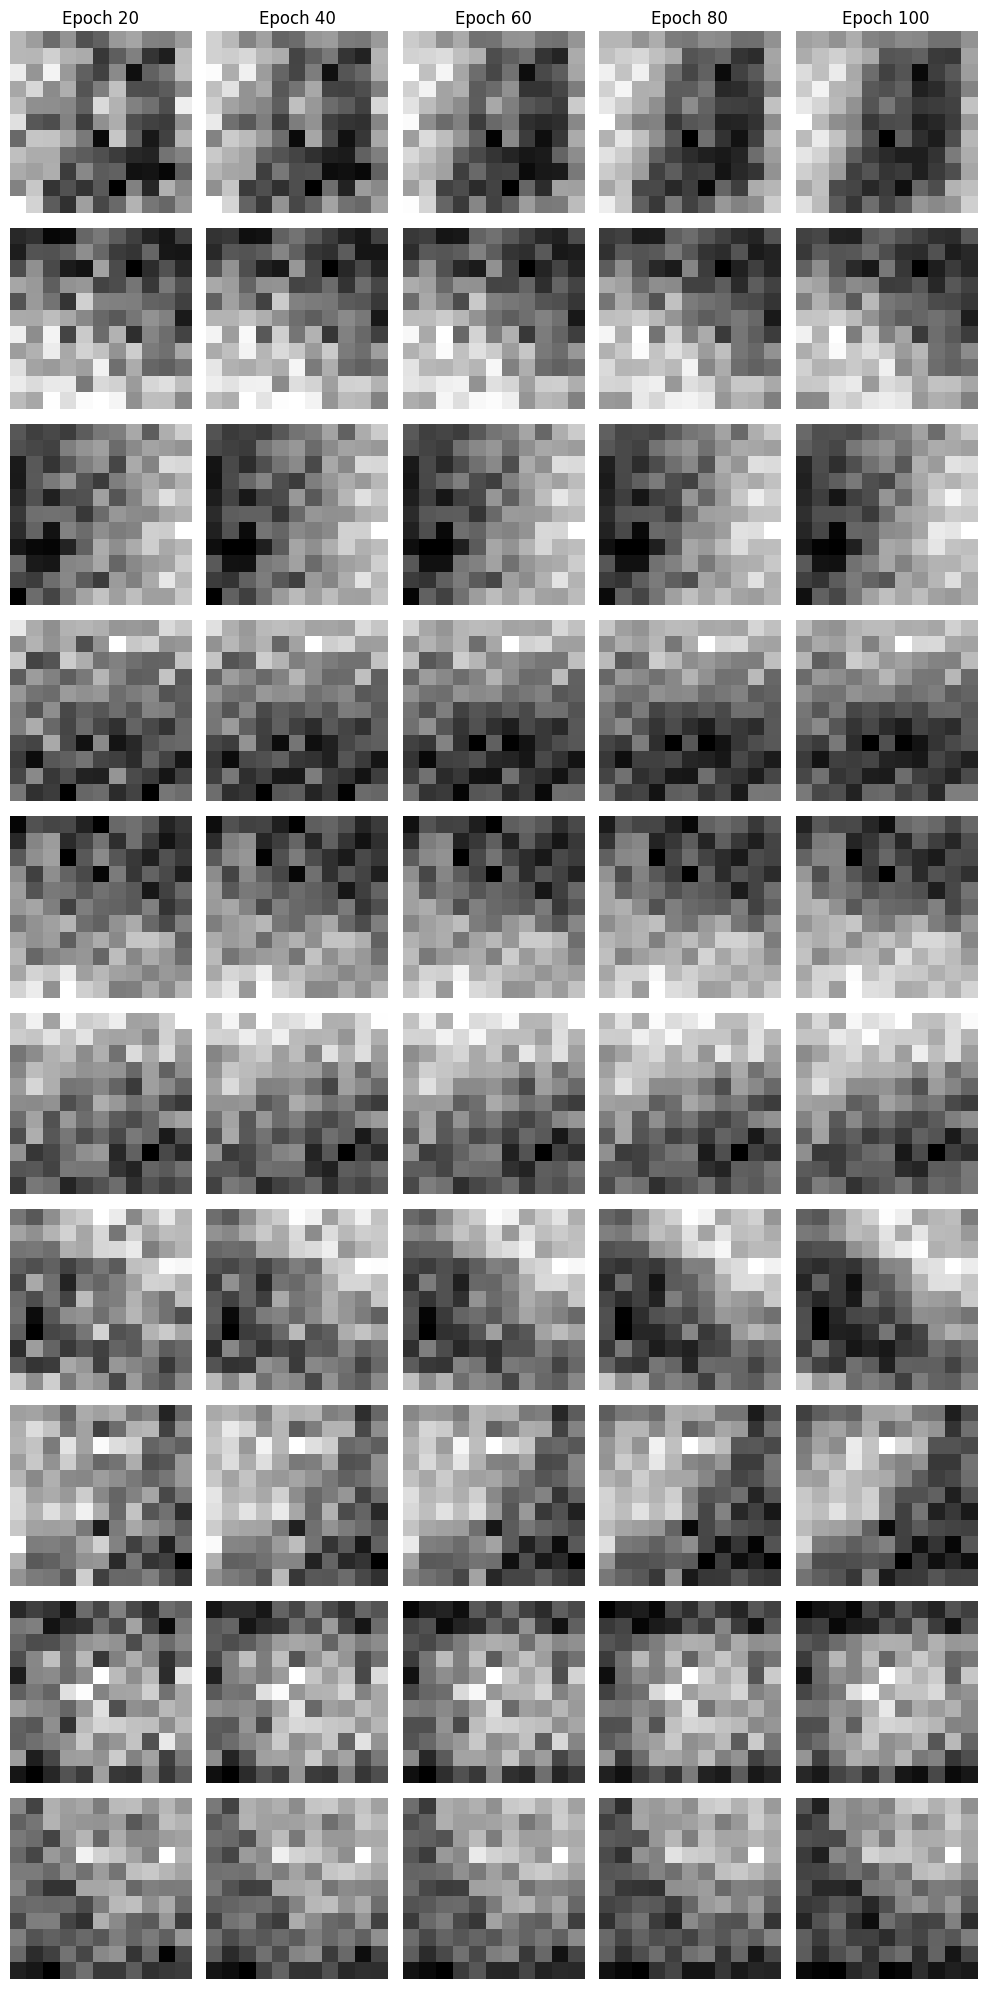

In [5]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_blurry_to_clear_100_epochs"

plot_kernel_evolution(model_dir, 12)


Mean of abs values: 0.4882
Standard deviation: 0.0592


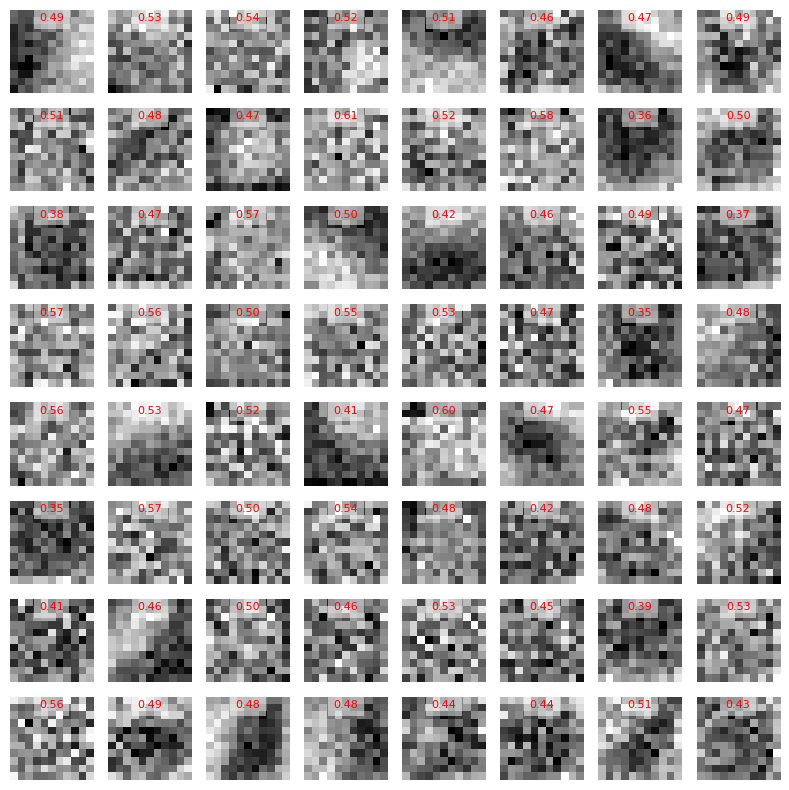

In [15]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_blurry_to_clear_100_epochs"

plot_first_layer_kernels(model_dir, 12)

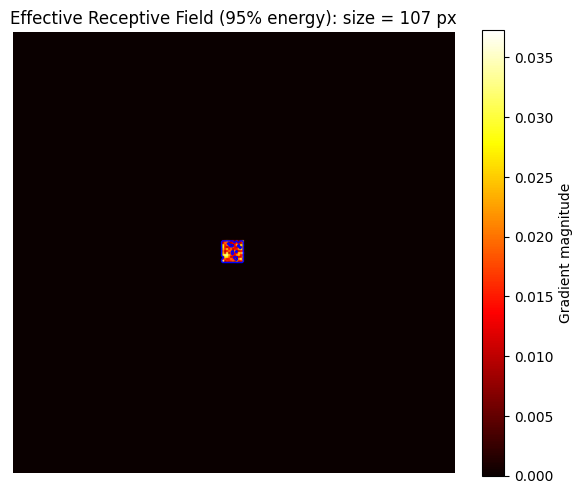

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_blurry_to_clear_100_epochs/model_checkpoint_epoch30.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model_from_checkpoint(model_dir, num_classes=12, device=device)
erf_map, erf_size = compute_erf_luo2016(model)

### Toybox (instances)

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_blur_100_epochs"
checkpoint_epoch = 100
checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{checkpoint_epoch}.pth")

num_classes = 360

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model_from_checkpoint(checkpoint_path, num_classes, device)

# Quantify the receptive field sizes.
toybox360_all_sizes, toybox360_valid_sizes = quantify_receptive_field_sizes(model, device)

if toybox360_valid_sizes:
    toybox360_avg_rf_size = np.mean(toybox360_valid_sizes)
    print(f"\nAverage receptive field size (over {len(toybox360_valid_sizes)} valid filters): {toybox360_avg_rf_size:.2f}")
else:
    print("No filters passed the R-squared threshold for a valid fit.")

Filter 0: Invalid fit (R² = 0.30)
Filter 1: Invalid fit (R² = 0.19)
Filter 2: Invalid fit (R² = 0.11)
Filter 3: RF size = 2.38 (R² = 0.52)
Filter 4: RF size = 3.84 (R² = 0.41)
Filter 5: Invalid fit (R² = 0.31)
Filter 6: Invalid fit (R² = 0.20)
Filter 7: Invalid fit (R² = 0.28)
Filter 8: Invalid fit (R² = 0.30)
Filter 9: Invalid fit (R² = 0.35)
Filter 10: Invalid fit (R² = 0.31)
Filter 11: Invalid fit (R² = 0.21)
Filter 12: Invalid fit (R² = 0.25)
Filter 13: Invalid fit (R² = 0.24)
Filter 14: Invalid fit (R² = 0.29)
Filter 15: Invalid fit (R² = 0.27)
Filter 16: RF size = 7.00 (R² = 0.43)
Filter 17: Invalid fit (R² = 0.36)
Filter 18: Invalid fit (R² = 0.35)
Filter 19: Invalid fit (R² = 0.11)
Filter 20: Invalid fit (R² = 0.22)
Filter 21: RF size = 2.45 (R² = 0.42)
Filter 22: Invalid fit (R² = 0.30)
Filter 23: Invalid fit (R² = 0.28)
Filter 24: Invalid fit (R² = 0.26)
Filter 25: Invalid fit (R² = 0.32)
Filter 26: Invalid fit (R² = 0.09)
Filter 27: Invalid fit (R² = 0.28)
Filter 28: Invalid

### Receptive field size across training

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_blur_100_epochs"

num_classes = 360
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
toybox360_rf_evolution = []
toybox360_rf_std = []  # List to store the standard deviation for each epoch

for epoch in epochs:
    checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
    model = load_model_from_checkpoint(checkpoint_path, num_classes, device)
    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

    # Convert to grayscale if necessary
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    for idx, kernel in enumerate(kernels):
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    avg_rf_size = np.mean(rf_sizes)
    std_rf_size = np.std(rf_sizes)

    toybox360_rf_evolution.append(avg_rf_size)
    toybox360_rf_std.append(std_rf_size)

    print(f"Average RF size for epoch {epoch}: {avg_rf_size:.2f} (std: {std_rf_size:.2f})")

Average RF size for epoch 10: 6.43 (std: 0.17)
Average RF size for epoch 20: 6.41 (std: 0.18)
Average RF size for epoch 30: 6.45 (std: 0.14)
Average RF size for epoch 40: 6.46 (std: 0.15)
Average RF size for epoch 50: 6.50 (std: 0.18)
Average RF size for epoch 60: 6.48 (std: 0.19)
Average RF size for epoch 70: 6.47 (std: 0.21)
Average RF size for epoch 80: 6.47 (std: 0.21)
Average RF size for epoch 90: 6.47 (std: 0.21)
Average RF size for epoch 100: 6.46 (std: 0.20)


In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_clear_100_epochs"

num_classes = 360
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
toybox360_rf_evolution_clear = []
toybox360_rf_std_clear = []  # List to store the standard deviation for each epoch

for epoch in epochs:
    checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
    model = load_model_from_checkpoint(checkpoint_path, num_classes, device)
    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

    # Convert to grayscale if necessary
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    for idx, kernel in enumerate(kernels):
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    avg_rf_size = np.mean(rf_sizes)
    std_rf_size = np.std(rf_sizes)

    toybox360_rf_evolution_clear.append(avg_rf_size)
    toybox360_rf_std_clear.append(std_rf_size)

    print(f"Average RF size for epoch {epoch}: {avg_rf_size:.2f} (std: {std_rf_size:.2f})")

Average RF size for epoch 10: 6.14 (std: 0.29)
Average RF size for epoch 20: 6.18 (std: 0.34)
Average RF size for epoch 30: 6.18 (std: 0.34)
Average RF size for epoch 40: 6.17 (std: 0.34)
Average RF size for epoch 50: 6.18 (std: 0.33)
Average RF size for epoch 60: 6.19 (std: 0.32)
Average RF size for epoch 70: 6.17 (std: 0.32)
Average RF size for epoch 80: 6.17 (std: 0.32)
Average RF size for epoch 90: 6.17 (std: 0.32)
Average RF size for epoch 100: 6.18 (std: 0.32)


In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/toybox360_full_blur"

num_classes = 360
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
toybox360_rf_evolution_blur = []
toybox360_rf_std_blur = []  # List to store the standard deviation for each epoch

for epoch in epochs:
    checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
    model = load_model_from_checkpoint(checkpoint_path, num_classes, device)
    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

    # Convert to grayscale if necessary
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    for idx, kernel in enumerate(kernels):
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    avg_rf_size = np.mean(rf_sizes)
    std_rf_size = np.std(rf_sizes)

    toybox360_rf_evolution_blur.append(avg_rf_size)
    toybox360_rf_std_blur.append(std_rf_size)

    print(f"Average RF size for epoch {epoch}: {avg_rf_size:.2f} (std: {std_rf_size:.2f})")

Average RF size for epoch 10: 6.45 (std: 0.15)
Average RF size for epoch 20: 6.41 (std: 0.15)
Average RF size for epoch 30: 6.40 (std: 0.16)
Average RF size for epoch 40: 6.39 (std: 0.14)
Average RF size for epoch 50: 6.39 (std: 0.14)
Average RF size for epoch 60: 6.39 (std: 0.14)
Average RF size for epoch 70: 6.38 (std: 0.14)
Average RF size for epoch 80: 6.38 (std: 0.18)
Average RF size for epoch 90: 6.37 (std: 0.17)
Average RF size for epoch 100: 6.39 (std: 0.18)


### Receptive field size across layers

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_blur_100_epochs"

num_classes = 360
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of layer identifiers to evaluate
layers = ["features.0", "features.3", "features.6", "features.8", "features.10"]

toybox360_rf_layers = []  # renamed from toybox12_rf_evolution

# Load only the epoch 100 checkpoint (end of training)
checkpoint_path = os.path.join(model_dir, "model_checkpoint_epoch100.pth")
model = load_model_from_checkpoint(checkpoint_path, num_classes, device)

# Loop through each specified layer
for layer_str in layers:
    # Extract the module index from the string (e.g., "features.3" -> 3)
    layer_index = int(layer_str.split(".")[1])
    # Access the corresponding layer from the feature extractor
    layer_module = model.backbone.feature_extractor[layer_index]
    # Extract the weights from the layer
    kernels = layer_module.weight.detach().cpu().numpy()

    # Convert to grayscale if necessary (i.e. if kernels have multiple input channels)
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    # Compute receptive field size for each kernel/filter
    for kernel in kernels:
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    # Calculate the average receptive field size for the current layer
    avg_rf_size = np.mean(rf_sizes)
    toybox360_rf_layers.append(avg_rf_size)
    print(f"Average RF size for layer {layer_str}: {avg_rf_size:.2f}")

Average RF size for layer features.0: 6.46
Average RF size for layer features.3: 2.72
Average RF size for layer features.6: 1.56
Average RF size for layer features.8: 1.57
Average RF size for layer features.10: 1.55


In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_clear_100_epochs"

num_classes = 360
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of layer identifiers to evaluate
layers = ["features.0", "features.3", "features.6", "features.8", "features.10"]

toybox360_rf_layers_clear = []  # renamed from toybox12_rf_evolution

# Load only the epoch 100 checkpoint (end of training)
checkpoint_path = os.path.join(model_dir, "model_checkpoint_epoch100.pth")
model = load_model_from_checkpoint(checkpoint_path, num_classes, device)

# Loop through each specified layer
for layer_str in layers:
    # Extract the module index from the string (e.g., "features.3" -> 3)
    layer_index = int(layer_str.split(".")[1])
    # Access the corresponding layer from the feature extractor
    layer_module = model.backbone.feature_extractor[layer_index]
    # Extract the weights from the layer
    kernels = layer_module.weight.detach().cpu().numpy()

    # Convert to grayscale if necessary (i.e. if kernels have multiple input channels)
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    # Compute receptive field size for each kernel/filter
    for kernel in kernels:
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    # Calculate the average receptive field size for the current layer
    avg_rf_size = np.mean(rf_sizes)
    toybox360_rf_layers_clear.append(avg_rf_size)
    print(f"Average RF size for layer {layer_str}: {avg_rf_size:.2f}")

Average RF size for layer features.0: 6.18
Average RF size for layer features.3: 2.70
Average RF size for layer features.6: 1.54
Average RF size for layer features.8: 1.56
Average RF size for layer features.10: 1.53


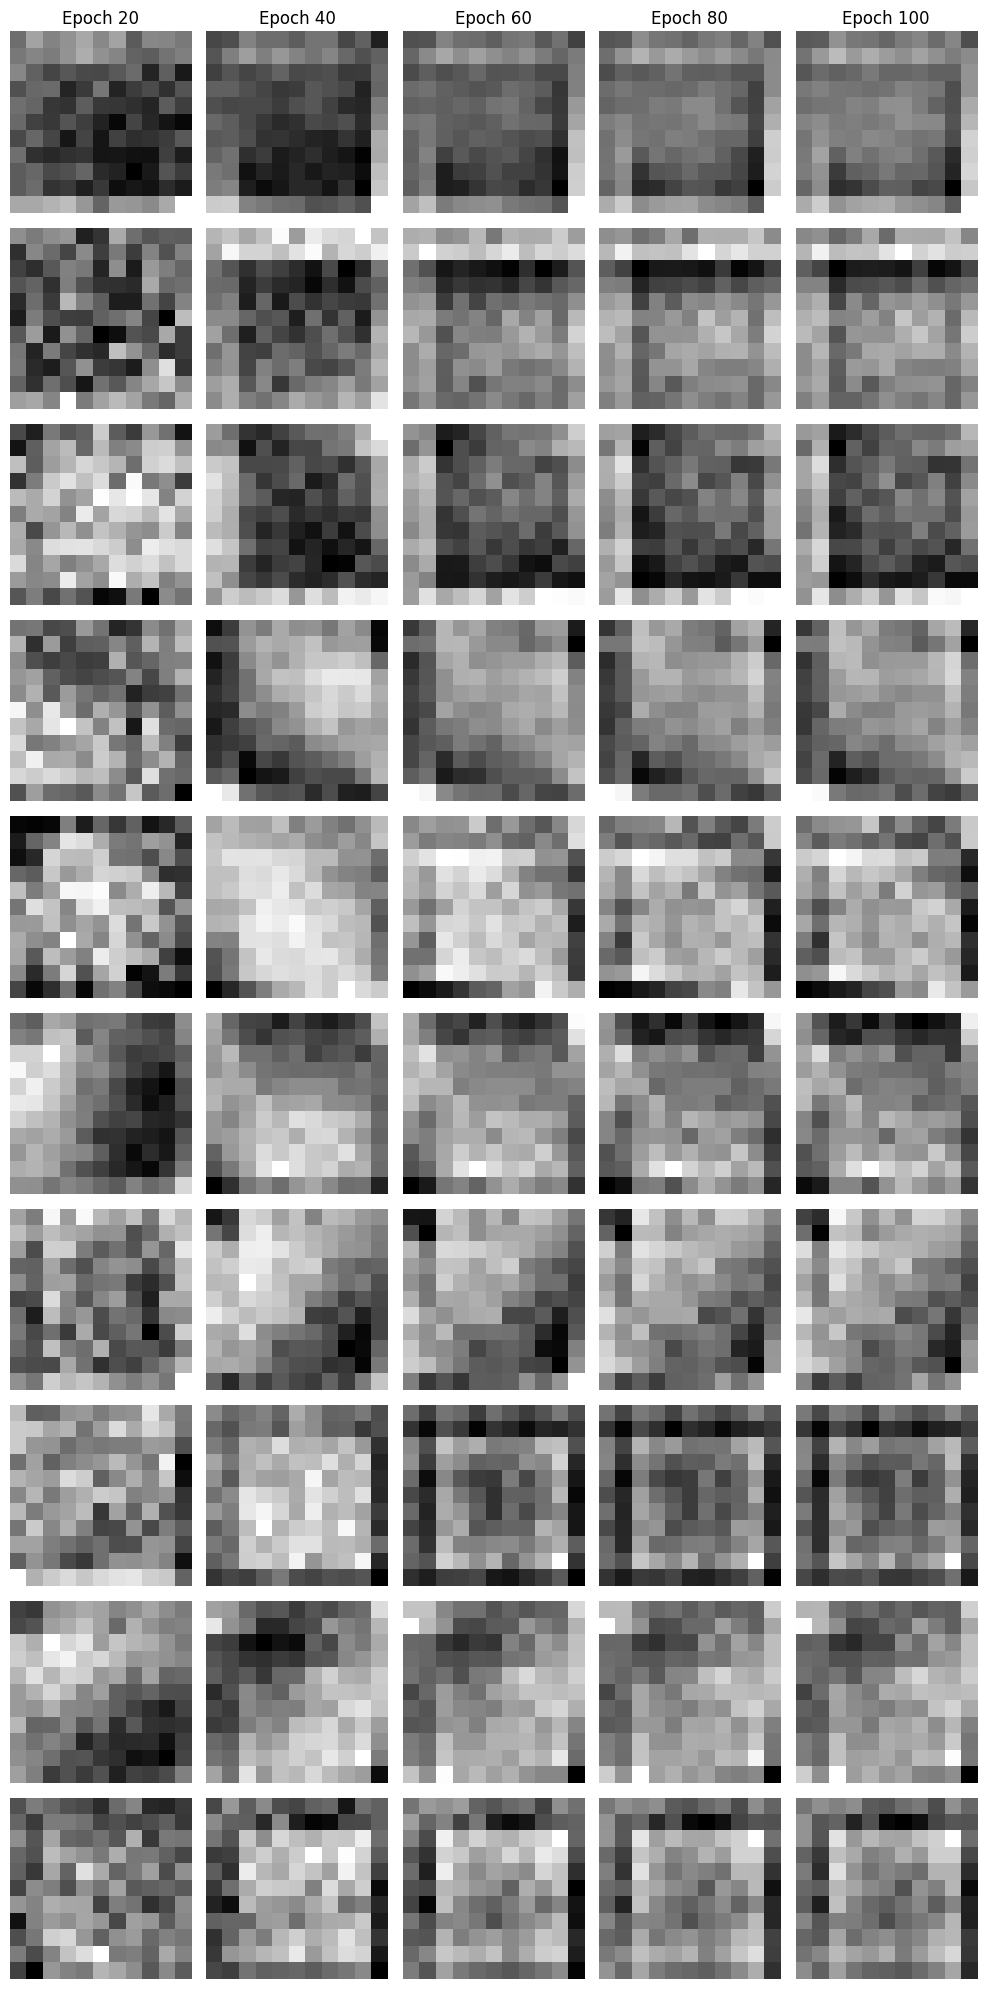

In [6]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_blur_100_epochs"

plot_kernel_evolution(model_dir, 360)


Mean of abs values: 0.5019
Standard deviation: 0.0589


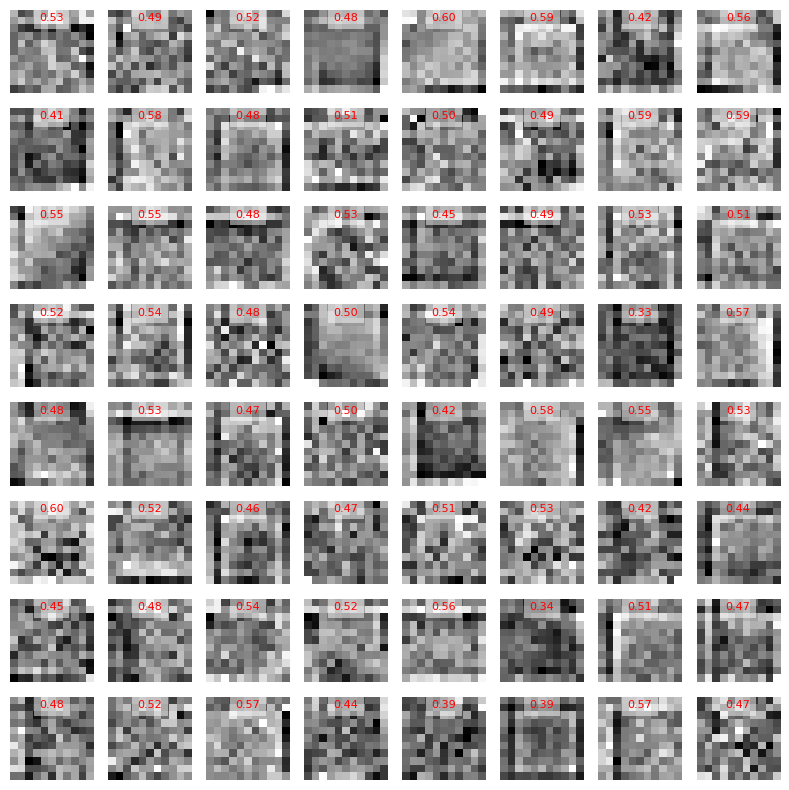

In [16]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_blur_100_epochs"

plot_first_layer_kernels(model_dir, 360)

### Faces

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/facescrub_blur_100_epochs"
checkpoint_epoch = 100
checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{checkpoint_epoch}.pth")

num_classes = 297

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model_from_checkpoint(checkpoint_path, num_classes, device)

# Quantify the receptive field sizes.
face_all_sizes, face_valid_sizes = quantify_receptive_field_sizes(model, device)

if face_valid_sizes:
    face_avg_rf_size = np.mean(face_valid_sizes)
    print(f"\nAverage receptive field size (over {len(face_valid_sizes)} valid filters): {face_avg_rf_size:.2f}")
else:
    print("No filters passed the R-squared threshold for a valid fit.")

### Receptive field size across training

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/facescrub_blur_100_epochs"

num_classes = 297
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
faces_rf_evolution = []
faces_rf_std = []  # List to store the standard deviation for each epoch

for epoch in epochs:
    checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
    model = load_model_from_checkpoint(checkpoint_path, num_classes, device)
    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

    # Convert to grayscale if necessary
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    for idx, kernel in enumerate(kernels):
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    avg_rf_size = np.mean(rf_sizes)
    std_rf_size = np.std(rf_sizes)

    faces_rf_evolution.append(avg_rf_size.astype(float))
    faces_rf_std.append(std_rf_size.astype(float))

    print(f"Average RF size for epoch {epoch}: {avg_rf_size:.2f} (std: {std_rf_size:.2f})")

Average RF size for epoch 10: 6.46 (std: 0.17)
Average RF size for epoch 20: 6.42 (std: 0.17)
Average RF size for epoch 30: 6.47 (std: 0.17)
Average RF size for epoch 40: 6.49 (std: 0.16)
Average RF size for epoch 50: 6.52 (std: 0.18)
Average RF size for epoch 60: 6.53 (std: 0.18)
Average RF size for epoch 70: 6.54 (std: 0.20)
Average RF size for epoch 80: 6.54 (std: 0.20)
Average RF size for epoch 90: 6.54 (std: 0.20)
Average RF size for epoch 100: 6.54 (std: 0.20)


In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/facescrub_clear_100_epochs"

num_classes = 297
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
faces_rf_evolution_clear = []
faces_rf_std_clear = []  # List to store the standard deviation for each epoch

for epoch in epochs:
    checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
    model = load_model_from_checkpoint(checkpoint_path, num_classes, device)
    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

    # Convert to grayscale if necessary
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    for idx, kernel in enumerate(kernels):
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    avg_rf_size = np.mean(rf_sizes)
    std_rf_size = np.std(rf_sizes)

    faces_rf_evolution_clear.append(avg_rf_size.astype(float))
    faces_rf_std_clear.append(std_rf_size.astype(float))

    print(f"Average RF size for epoch {epoch}: {avg_rf_size:.2f} (std: {std_rf_size:.2f})")

Average RF size for epoch 10: 6.39 (std: 0.21)
Average RF size for epoch 20: 6.40 (std: 0.24)
Average RF size for epoch 30: 6.41 (std: 0.24)
Average RF size for epoch 40: 6.42 (std: 0.26)
Average RF size for epoch 50: 6.42 (std: 0.25)
Average RF size for epoch 60: 6.43 (std: 0.26)
Average RF size for epoch 70: 6.42 (std: 0.26)
Average RF size for epoch 80: 6.44 (std: 0.26)
Average RF size for epoch 90: 6.44 (std: 0.26)
Average RF size for epoch 100: 6.44 (std: 0.26)


In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/facescrub_full_blur"

num_classes = 297
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
faces_rf_evolution_blur = []
faces_rf_std_blur = []  # List to store the standard deviation for each epoch

for epoch in epochs:
    checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
    model = load_model_from_checkpoint(checkpoint_path, num_classes, device)
    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

    # Convert to grayscale if necessary
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    for idx, kernel in enumerate(kernels):
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    avg_rf_size = np.mean(rf_sizes)
    std_rf_size = np.std(rf_sizes)

    faces_rf_evolution_blur.append(avg_rf_size.astype(float))
    faces_rf_std_blur.append(std_rf_size.astype(float))

    print(f"Average RF size for epoch {epoch}: {avg_rf_size:.2f} (std: {std_rf_size:.2f})")

Average RF size for epoch 10: 6.43 (std: 0.18)
Average RF size for epoch 20: 6.39 (std: 0.16)
Average RF size for epoch 30: 6.39 (std: 0.16)
Average RF size for epoch 40: 6.38 (std: 0.16)
Average RF size for epoch 50: 6.38 (std: 0.16)
Average RF size for epoch 60: 6.38 (std: 0.16)
Average RF size for epoch 70: 6.38 (std: 0.16)
Average RF size for epoch 80: 6.38 (std: 0.16)
Average RF size for epoch 90: 6.38 (std: 0.16)
Average RF size for epoch 100: 6.38 (std: 0.16)


### Receptive field size across layers

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/facescrub_blur_100_epochs"

num_classes = 297
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of layer identifiers to evaluate
layers = ["features.0", "features.3", "features.6", "features.8", "features.10"]

faces_rf_layers = []  # renamed from toybox12_rf_evolution

# Load only the epoch 100 checkpoint (end of training)
checkpoint_path = os.path.join(model_dir, "model_checkpoint_epoch100.pth")
model = load_model_from_checkpoint(checkpoint_path, num_classes, device)

# Loop through each specified layer
for layer_str in layers:
    # Extract the module index from the string (e.g., "features.3" -> 3)
    layer_index = int(layer_str.split(".")[1])
    # Access the corresponding layer from the feature extractor
    layer_module = model.backbone.feature_extractor[layer_index]
    # Extract the weights from the layer
    kernels = layer_module.weight.detach().cpu().numpy()

    # Convert to grayscale if necessary (i.e. if kernels have multiple input channels)
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    # Compute receptive field size for each kernel/filter
    for kernel in kernels:
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    # Calculate the average receptive field size for the current layer
    avg_rf_size = np.mean(rf_sizes)
    faces_rf_layers.append(avg_rf_size)
    print(f"Average RF size for layer {layer_str}: {avg_rf_size:.2f}")

Average RF size for layer features.0: 6.54
Average RF size for layer features.3: 2.75
Average RF size for layer features.6: 1.54
Average RF size for layer features.8: 1.56
Average RF size for layer features.10: 1.55


In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/facescrub_clear_100_epochs"

num_classes = 297
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of layer identifiers to evaluate
layers = ["features.0", "features.3", "features.6", "features.8", "features.10"]

faces_rf_layers_clear = []  # renamed from toybox12_rf_evolution

# Load only the epoch 100 checkpoint (end of training)
checkpoint_path = os.path.join(model_dir, "model_checkpoint_epoch100.pth")
model = load_model_from_checkpoint(checkpoint_path, num_classes, device)

# Loop through each specified layer
for layer_str in layers:
    # Extract the module index from the string (e.g., "features.3" -> 3)
    layer_index = int(layer_str.split(".")[1])
    # Access the corresponding layer from the feature extractor
    layer_module = model.backbone.feature_extractor[layer_index]
    # Extract the weights from the layer
    kernels = layer_module.weight.detach().cpu().numpy()

    # Convert to grayscale if necessary (i.e. if kernels have multiple input channels)
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    # Compute receptive field size for each kernel/filter
    for kernel in kernels:
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    # Calculate the average receptive field size for the current layer
    avg_rf_size = np.mean(rf_sizes)
    faces_rf_layers_clear.append(avg_rf_size)
    print(f"Average RF size for layer {layer_str}: {avg_rf_size:.2f}")

Average RF size for layer features.0: 6.44
Average RF size for layer features.3: 2.72
Average RF size for layer features.6: 1.53
Average RF size for layer features.8: 1.57
Average RF size for layer features.10: 1.55


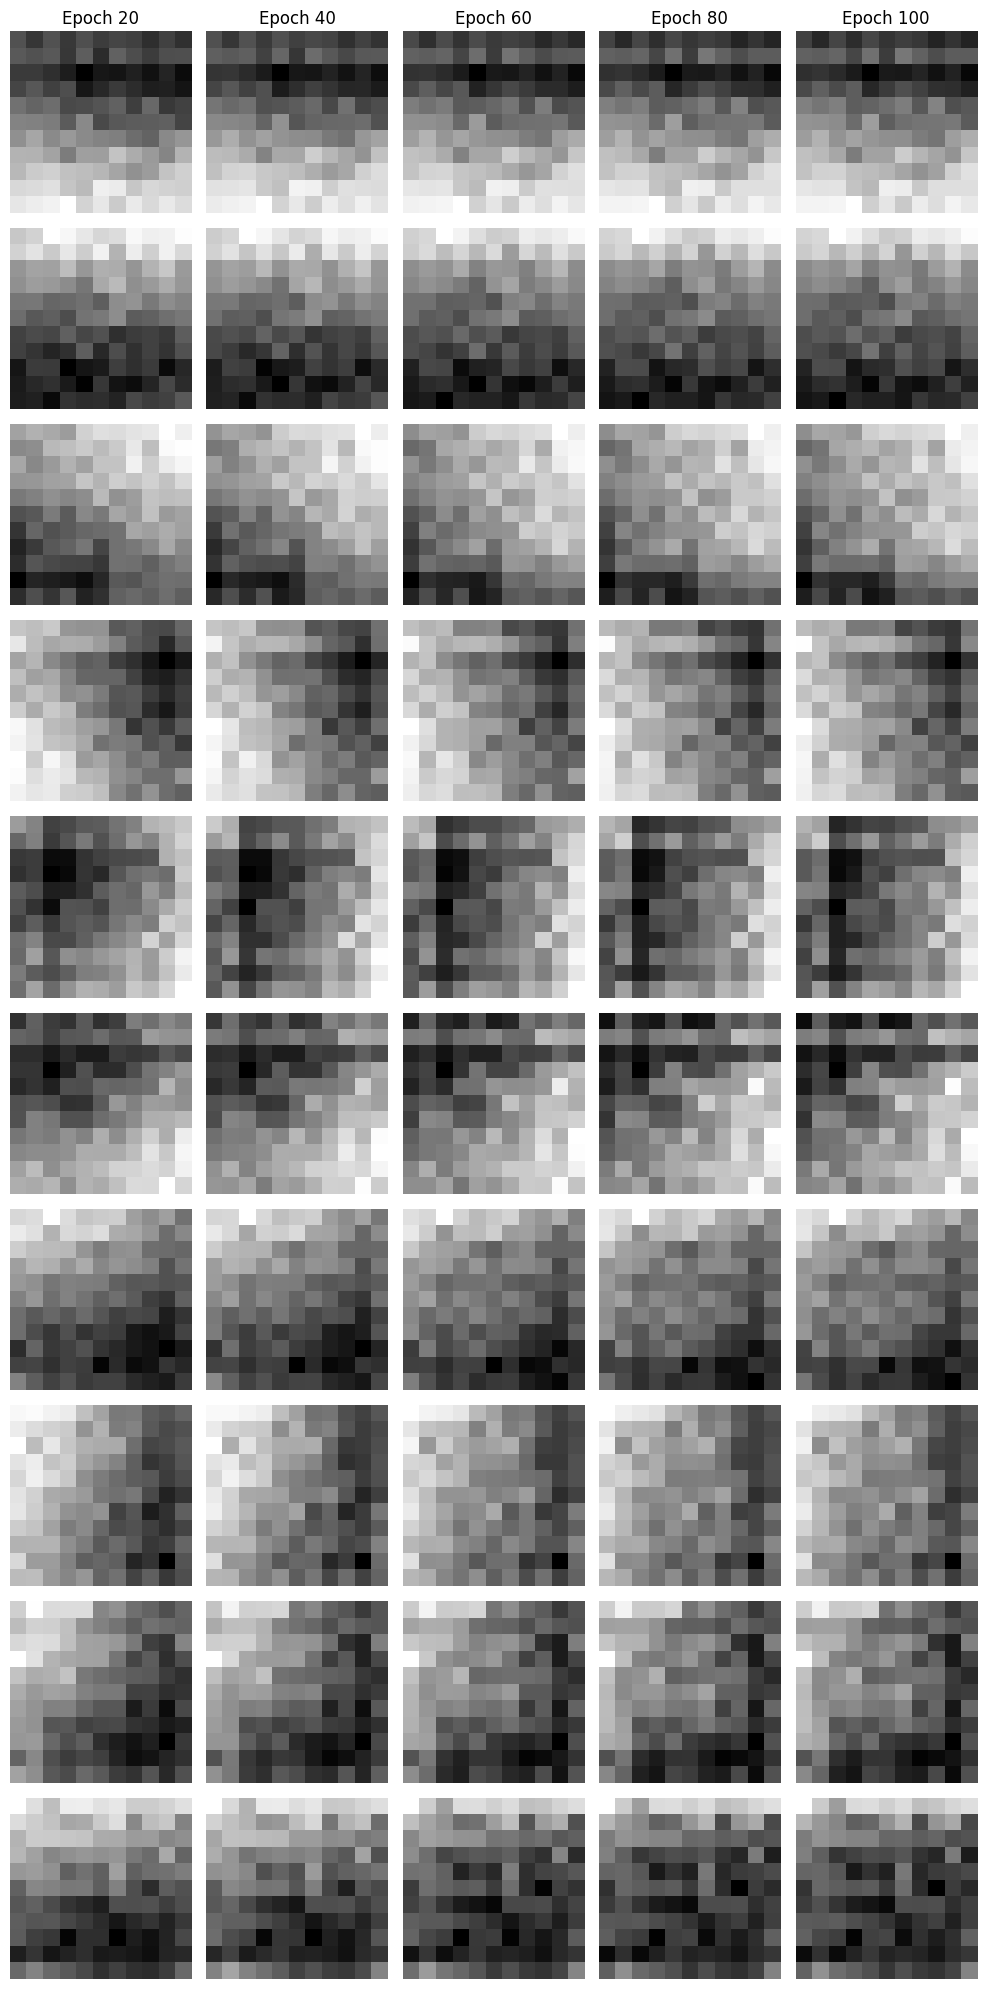

In [7]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/facescrub_blur_100_epochs"

plot_kernel_evolution(model_dir, 297)


Mean of abs values: 0.4849
Standard deviation: 0.0638


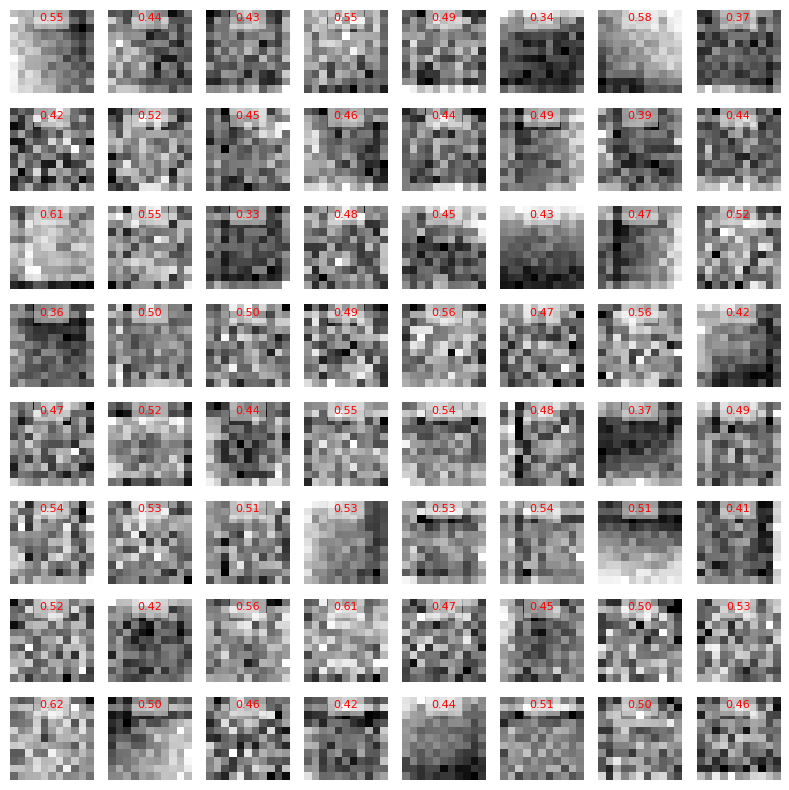

In [17]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/facescrub_blur_100_epochs"

plot_first_layer_kernels(model_dir, 297)

### ImageNet-12

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN12_blurry_to_clear_100_epochs"
checkpoint_epoch = 100
checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{checkpoint_epoch}.pth")

num_classes = 12

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model_from_checkpoint(checkpoint_path, num_classes, device)

# Quantify the receptive field sizes.
IN12_all_sizes, IN12_valid_sizes = quantify_receptive_field_sizes(model, device)

if IN12_valid_sizes:
    IN12_avg_rf_size = np.mean(IN12_valid_sizes)
    print(f"\nAverage receptive field size (over {len(IN12_valid_sizes)} valid filters): {IN12_avg_rf_size:.2f}")
else:
    print("No filters passed the R-squared threshold for a valid fit.")

### Receptive field size across training

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN12_blurry_to_clear_100_epochs"

num_classes = 12
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
IN12_rf_evolution = []
IN12_rf_std = []  # List to store the standard deviation for each epoch

for epoch in epochs:
    checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
    model = load_model_from_checkpoint(checkpoint_path, num_classes, device)
    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

    # Convert to grayscale if necessary
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    for idx, kernel in enumerate(kernels):
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    avg_rf_size = np.mean(rf_sizes)
    std_rf_size = np.std(rf_sizes)

    IN12_rf_evolution.append(avg_rf_size)
    IN12_rf_std.append(std_rf_size)

    print(f"Average RF size for epoch {epoch}: {avg_rf_size:.2f} (std: {std_rf_size:.2f})")

Average RF size for epoch 10: 6.47 (std: 0.17)
Average RF size for epoch 20: 6.47 (std: 0.15)
Average RF size for epoch 30: 6.44 (std: 0.15)
Average RF size for epoch 40: 6.43 (std: 0.15)
Average RF size for epoch 50: 6.45 (std: 0.15)
Average RF size for epoch 60: 6.45 (std: 0.15)
Average RF size for epoch 70: 6.46 (std: 0.14)
Average RF size for epoch 80: 6.45 (std: 0.14)
Average RF size for epoch 90: 6.45 (std: 0.14)
Average RF size for epoch 100: 6.45 (std: 0.13)


In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN12_clear_100_epochs"

num_classes = 12
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
IN12_rf_evolution_clear = []
IN12_rf_std_clear = []  # List to store the standard deviation for each epoch

for epoch in epochs:
    checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
    model = load_model_from_checkpoint(checkpoint_path, num_classes, device)
    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

    # Convert to grayscale if necessary
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    for idx, kernel in enumerate(kernels):
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    avg_rf_size = np.mean(rf_sizes)
    std_rf_size = np.std(rf_sizes)

    IN12_rf_evolution_clear.append(avg_rf_size)
    IN12_rf_std_clear.append(std_rf_size)

    print(f"Average RF size for epoch {epoch}: {avg_rf_size:.2f} (std: {std_rf_size:.2f})")

Average RF size for epoch 10: 6.14 (std: 0.20)
Average RF size for epoch 20: 6.07 (std: 0.24)
Average RF size for epoch 30: 6.02 (std: 0.25)
Average RF size for epoch 40: 6.01 (std: 0.27)
Average RF size for epoch 50: 6.00 (std: 0.27)
Average RF size for epoch 60: 5.99 (std: 0.28)
Average RF size for epoch 70: 5.99 (std: 0.27)
Average RF size for epoch 80: 5.99 (std: 0.27)
Average RF size for epoch 90: 5.99 (std: 0.27)
Average RF size for epoch 100: 5.99 (std: 0.27)


In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/IN12_full_blur"

num_classes = 12
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
IN12_rf_evolution_blur = []
IN12_rf_std_blur = []  # List to store the standard deviation for each epoch

for epoch in epochs:
    checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
    model = load_model_from_checkpoint(checkpoint_path, num_classes, device)
    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

    # Convert to grayscale if necessary
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    for idx, kernel in enumerate(kernels):
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    avg_rf_size = np.mean(rf_sizes)
    std_rf_size = np.std(rf_sizes)

    IN12_rf_evolution_blur.append(avg_rf_size)
    IN12_rf_std_blur.append(std_rf_size)

    print(f"Average RF size for epoch {epoch}: {avg_rf_size:.2f} (std: {std_rf_size:.2f})")

Average RF size for epoch 10: 6.44 (std: 0.16)
Average RF size for epoch 20: 6.43 (std: 0.15)
Average RF size for epoch 30: 6.41 (std: 0.15)
Average RF size for epoch 40: 6.41 (std: 0.14)
Average RF size for epoch 50: 6.41 (std: 0.14)
Average RF size for epoch 60: 6.40 (std: 0.16)
Average RF size for epoch 70: 6.36 (std: 0.17)
Average RF size for epoch 80: 6.36 (std: 0.18)
Average RF size for epoch 90: 6.35 (std: 0.17)
Average RF size for epoch 100: 6.35 (std: 0.17)


### Receptive field size across layers

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN12_blurry_to_clear_100_epochs"

num_classes = 12
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of layer identifiers to evaluate
layers = ["features.0", "features.3", "features.6", "features.8", "features.10"]

IN12_rf_layers = []  # renamed from toybox12_rf_evolution

# Load only the epoch 100 checkpoint (end of training)
checkpoint_path = os.path.join(model_dir, "model_checkpoint_epoch100.pth")
model = load_model_from_checkpoint(checkpoint_path, num_classes, device)

# Loop through each specified layer
for layer_str in layers:
    # Extract the module index from the string (e.g., "features.3" -> 3)
    layer_index = int(layer_str.split(".")[1])
    # Access the corresponding layer from the feature extractor
    layer_module = model.backbone.feature_extractor[layer_index]
    # Extract the weights from the layer
    kernels = layer_module.weight.detach().cpu().numpy()

    # Convert to grayscale if necessary (i.e. if kernels have multiple input channels)
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    # Compute receptive field size for each kernel/filter
    for kernel in kernels:
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    # Calculate the average receptive field size for the current layer
    avg_rf_size = np.mean(rf_sizes)
    IN12_rf_layers.append(avg_rf_size)
    print(f"Average RF size for layer {layer_str}: {avg_rf_size:.2f}")

Average RF size for layer features.0: 6.45
Average RF size for layer features.3: 2.74
Average RF size for layer features.6: 1.56
Average RF size for layer features.8: 1.55
Average RF size for layer features.10: 1.58


In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN12_clear_100_epochs"

num_classes = 12
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of layer identifiers to evaluate
layers = ["features.0", "features.3", "features.6", "features.8", "features.10"]

IN12_rf_layers_clear = []  # renamed from toybox12_rf_evolution

# Load only the epoch 100 checkpoint (end of training)
checkpoint_path = os.path.join(model_dir, "model_checkpoint_epoch100.pth")
model = load_model_from_checkpoint(checkpoint_path, num_classes, device)

# Loop through each specified layer
for layer_str in layers:
    # Extract the module index from the string (e.g., "features.3" -> 3)
    layer_index = int(layer_str.split(".")[1])
    # Access the corresponding layer from the feature extractor
    layer_module = model.backbone.feature_extractor[layer_index]
    # Extract the weights from the layer
    kernels = layer_module.weight.detach().cpu().numpy()

    # Convert to grayscale if necessary (i.e. if kernels have multiple input channels)
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    # Compute receptive field size for each kernel/filter
    for kernel in kernels:
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    # Calculate the average receptive field size for the current layer
    avg_rf_size = np.mean(rf_sizes)
    IN12_rf_layers_clear.append(avg_rf_size)
    print(f"Average RF size for layer {layer_str}: {avg_rf_size:.2f}")

Average RF size for layer features.0: 5.99
Average RF size for layer features.3: 2.73
Average RF size for layer features.6: 1.54
Average RF size for layer features.8: 1.56
Average RF size for layer features.10: 1.57


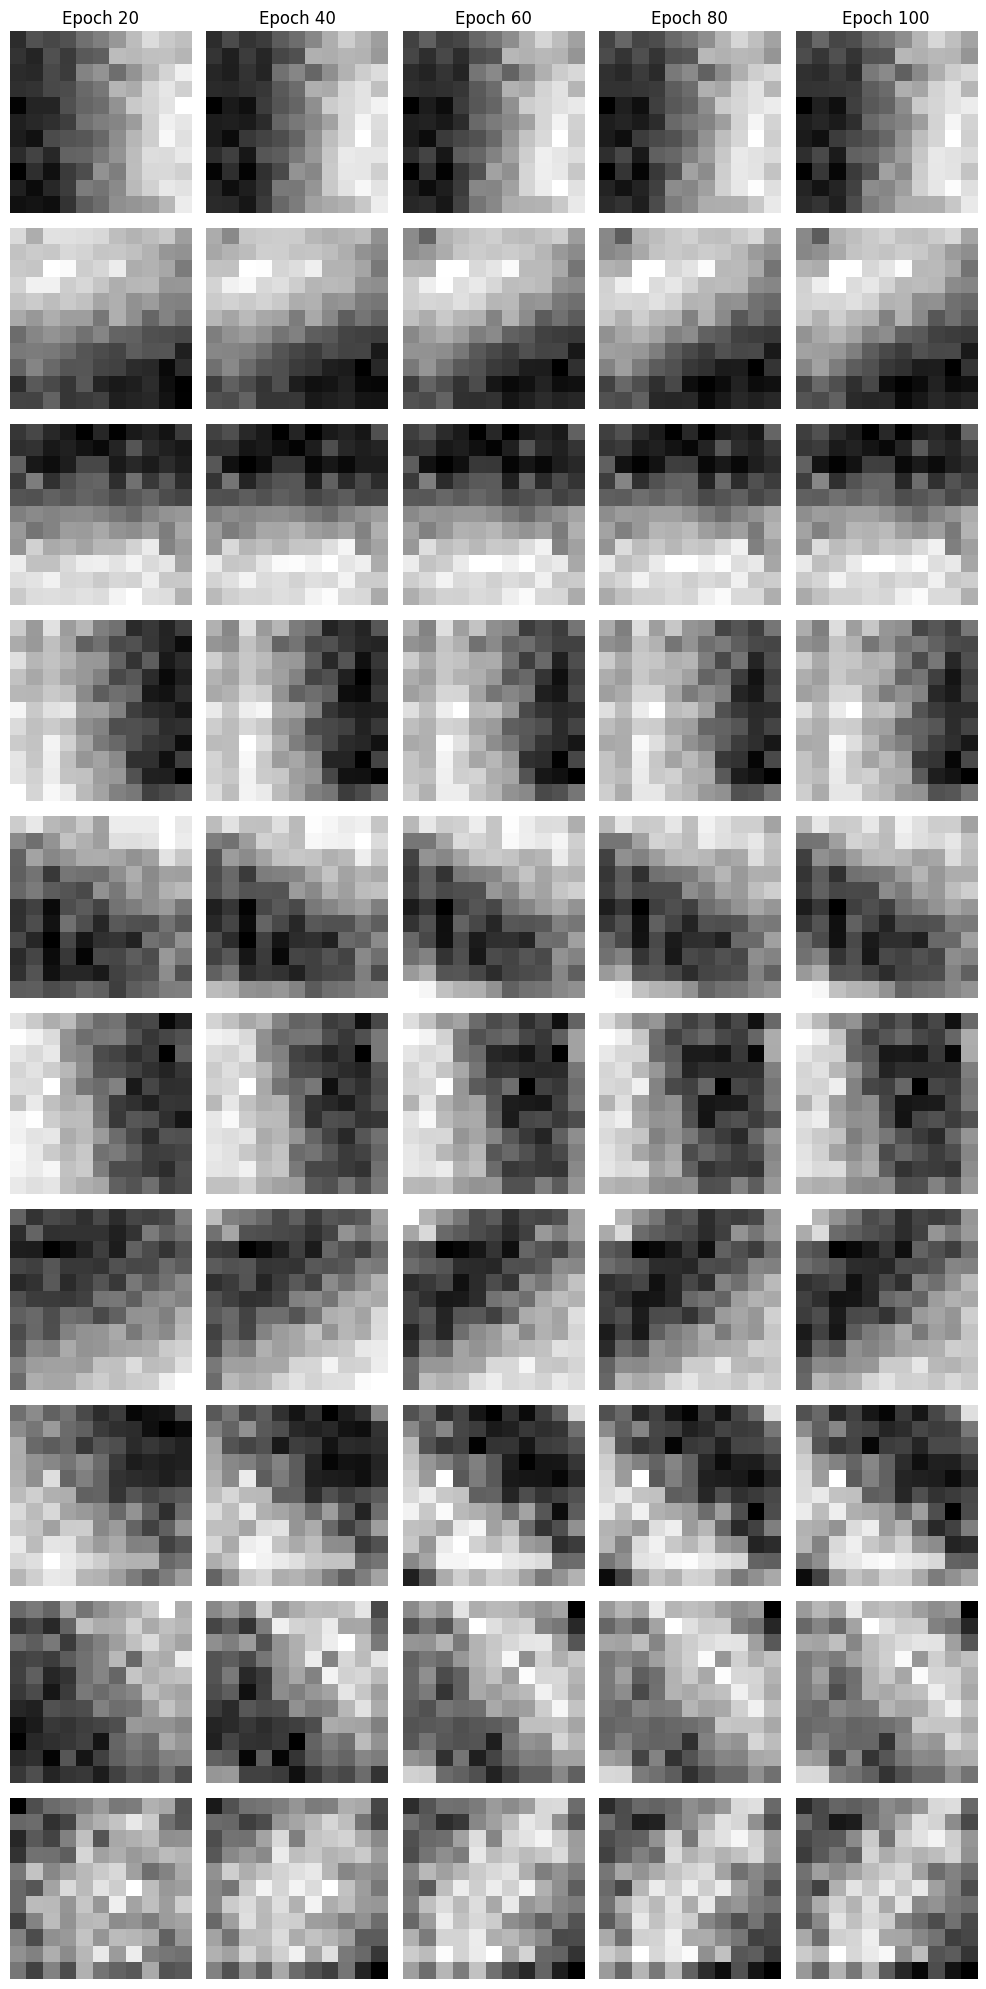

In [9]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN12_blurry_to_clear_100_epochs"

plot_kernel_evolution(model_dir, 12)


Mean of abs values: 0.5029
Standard deviation: 0.0580


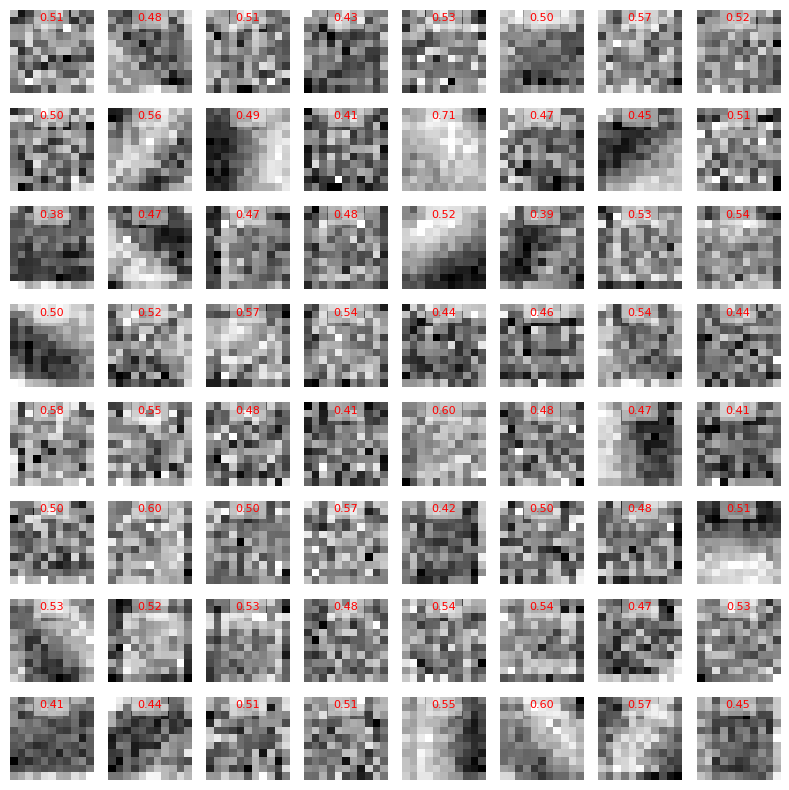

In [18]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN12_blurry_to_clear_100_epochs"

plot_first_layer_kernels(model_dir, 12)

### ImageNet-100

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_blur"

checkpoint_epoch = 100
checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{checkpoint_epoch}.pth")

num_classes = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model_from_checkpoint(checkpoint_path, num_classes, device)

# Quantify the receptive field sizes.
IN100_all_sizes, IN100_valid_sizes = quantify_receptive_field_sizes(model, device)

if IN100_valid_sizes:
    IN100_avg_rf_size = np.mean(IN100_valid_sizes)
    print(f"\nAverage receptive field size (over {len(IN100_valid_sizes)} valid filters): {IN100_avg_rf_size:.2f}")
else:
    print("No filters passed the R-squared threshold for a valid fit.")

### Receptive field size across training

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_blur"

num_classes = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
IN100_rf_evolution = []
IN100_rf_std = []  # List to store the standard deviation for each epoch

for epoch in epochs:
    checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
    model = load_model_from_checkpoint(checkpoint_path, num_classes, device)
    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

    # Convert to grayscale if necessary
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    for idx, kernel in enumerate(kernels):
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    avg_rf_size = np.mean(rf_sizes)
    std_rf_size = np.std(rf_sizes)

    IN100_rf_evolution.append(avg_rf_size)
    IN100_rf_std.append(std_rf_size)

    print(f"Average RF size for epoch {epoch}: {avg_rf_size:.2f} (std: {std_rf_size:.2f})")

Average RF size for epoch 10: 6.39 (std: 0.18)
Average RF size for epoch 20: 6.40 (std: 0.20)
Average RF size for epoch 30: 6.48 (std: 0.19)
Average RF size for epoch 40: 6.50 (std: 0.24)
Average RF size for epoch 50: 6.48 (std: 0.24)
Average RF size for epoch 60: 6.49 (std: 0.31)
Average RF size for epoch 70: 6.50 (std: 0.32)
Average RF size for epoch 80: 6.32 (std: 0.56)
Average RF size for epoch 90: 6.33 (std: 0.31)
Average RF size for epoch 100: 6.31 (std: 0.31)


In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_clear"

num_classes = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
IN100_rf_evolution_clear = []
IN100_rf_std_clear = []  # List to store the standard deviation for each epoch

for epoch in epochs:
    checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
    model = load_model_from_checkpoint(checkpoint_path, num_classes, device)
    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

    # Convert to grayscale
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    for idx, kernel in enumerate(kernels):
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    avg_rf_size = np.mean(rf_sizes)
    std_rf_size = np.std(rf_sizes)

    IN100_rf_evolution_clear.append(avg_rf_size)
    IN100_rf_std_clear.append(std_rf_size)

    print(f"Average RF size for epoch {epoch}: {avg_rf_size:.2f} (std: {std_rf_size:.2f})")

Average RF size for epoch 10: 5.98 (std: 0.37)
Average RF size for epoch 20: 5.95 (std: 0.38)
Average RF size for epoch 30: 5.97 (std: 0.40)
Average RF size for epoch 40: 5.95 (std: 0.39)
Average RF size for epoch 50: 5.93 (std: 0.40)
Average RF size for epoch 60: 5.91 (std: 0.42)
Average RF size for epoch 70: 5.87 (std: 0.41)
Average RF size for epoch 80: 5.84 (std: 0.40)
Average RF size for epoch 90: 5.81 (std: 0.40)
Average RF size for epoch 100: 5.79 (std: 0.42)


In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/IN100_full_blur"

num_classes = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
IN100_rf_evolution_blur = []
IN100_rf_std_blur = []  # List to store the standard deviation for each epoch

for epoch in epochs:
    checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
    model = load_model_from_checkpoint(checkpoint_path, num_classes, device)
    kernels = model.backbone.feature_extractor[0].weight.detach().cpu().numpy()

    # Convert to grayscale
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    for idx, kernel in enumerate(kernels):
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    avg_rf_size = np.mean(rf_sizes)
    std_rf_size = np.std(rf_sizes)

    IN100_rf_evolution_blur.append(avg_rf_size)
    IN100_rf_std_blur.append(std_rf_size)

    print(f"Average RF size for epoch {epoch}: {avg_rf_size:.2f} (std: {std_rf_size:.2f})")

Average RF size for epoch 10: 6.36 (std: 0.16)
Average RF size for epoch 20: 6.35 (std: 0.18)
Average RF size for epoch 30: 6.34 (std: 0.18)
Average RF size for epoch 40: 6.35 (std: 0.17)
Average RF size for epoch 50: 6.34 (std: 0.17)
Average RF size for epoch 60: 6.30 (std: 0.25)
Average RF size for epoch 70: 6.32 (std: 0.21)
Average RF size for epoch 80: 6.32 (std: 0.18)
Average RF size for epoch 90: 6.37 (std: 0.23)
Average RF size for epoch 100: 6.37 (std: 0.23)


### Receptive field size across layers

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_blur"

num_classes = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of layer identifiers to evaluate
layers = ["features.0", "features.3", "features.6", "features.8", "features.10"]

IN100_rf_layers = []  # renamed from toybox12_rf_evolution

# Load only the epoch 100 checkpoint (end of training)
checkpoint_path = os.path.join(model_dir, "model_checkpoint_epoch100.pth")
model = load_model_from_checkpoint(checkpoint_path, num_classes, device)

# Loop through each specified layer
for layer_str in layers:
    # Extract the module index from the string (e.g., "features.3" -> 3)
    layer_index = int(layer_str.split(".")[1])
    # Access the corresponding layer from the feature extractor
    layer_module = model.backbone.feature_extractor[layer_index]
    # Extract the weights from the layer
    kernels = layer_module.weight.detach().cpu().numpy()

    # Convert to grayscale if necessary (i.e. if kernels have multiple input channels)
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    # Compute receptive field size for each kernel/filter
    for kernel in kernels:
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    # Calculate the average receptive field size for the current layer
    avg_rf_size = np.mean(rf_sizes)
    IN100_rf_layers.append(avg_rf_size)
    print(f"Average RF size for layer {layer_str}: {avg_rf_size:.2f}")

Average RF size for layer features.0: 6.31
Average RF size for layer features.3: 2.61
Average RF size for layer features.6: 1.49
Average RF size for layer features.8: 1.56
Average RF size for layer features.10: 1.57


In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_clear"

num_classes = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of layer identifiers to evaluate
layers = ["features.0", "features.3", "features.6", "features.8", "features.10"]

IN100_rf_layers_clear = []  # renamed from toybox12_rf_evolution

# Load only the epoch 100 checkpoint (end of training)
checkpoint_path = os.path.join(model_dir, "model_checkpoint_epoch100.pth")
model = load_model_from_checkpoint(checkpoint_path, num_classes, device)

# Loop through each specified layer
for layer_str in layers:
    # Extract the module index from the string (e.g., "features.3" -> 3)
    layer_index = int(layer_str.split(".")[1])
    # Access the corresponding layer from the feature extractor
    layer_module = model.backbone.feature_extractor[layer_index]
    # Extract the weights from the layer
    kernels = layer_module.weight.detach().cpu().numpy()

    # Convert to grayscale if necessary (i.e. if kernels have multiple input channels)
    if kernels.shape[1] > 1:
        kernels = np.mean(kernels, axis=1)
    else:
        kernels = kernels.squeeze(1)

    rf_sizes = []
    # Compute receptive field size for each kernel/filter
    for kernel in kernels:
        size = compute_rf_size_moments(kernel)
        rf_sizes.append(size)

    # Calculate the average receptive field size for the current layer
    avg_rf_size = np.mean(rf_sizes)
    IN100_rf_layers_clear.append(avg_rf_size)
    print(f"Average RF size for layer {layer_str}: {avg_rf_size:.2f}")

Average RF size for layer features.0: 5.79
Average RF size for layer features.3: 2.59
Average RF size for layer features.6: 1.49
Average RF size for layer features.8: 1.53
Average RF size for layer features.10: 1.55


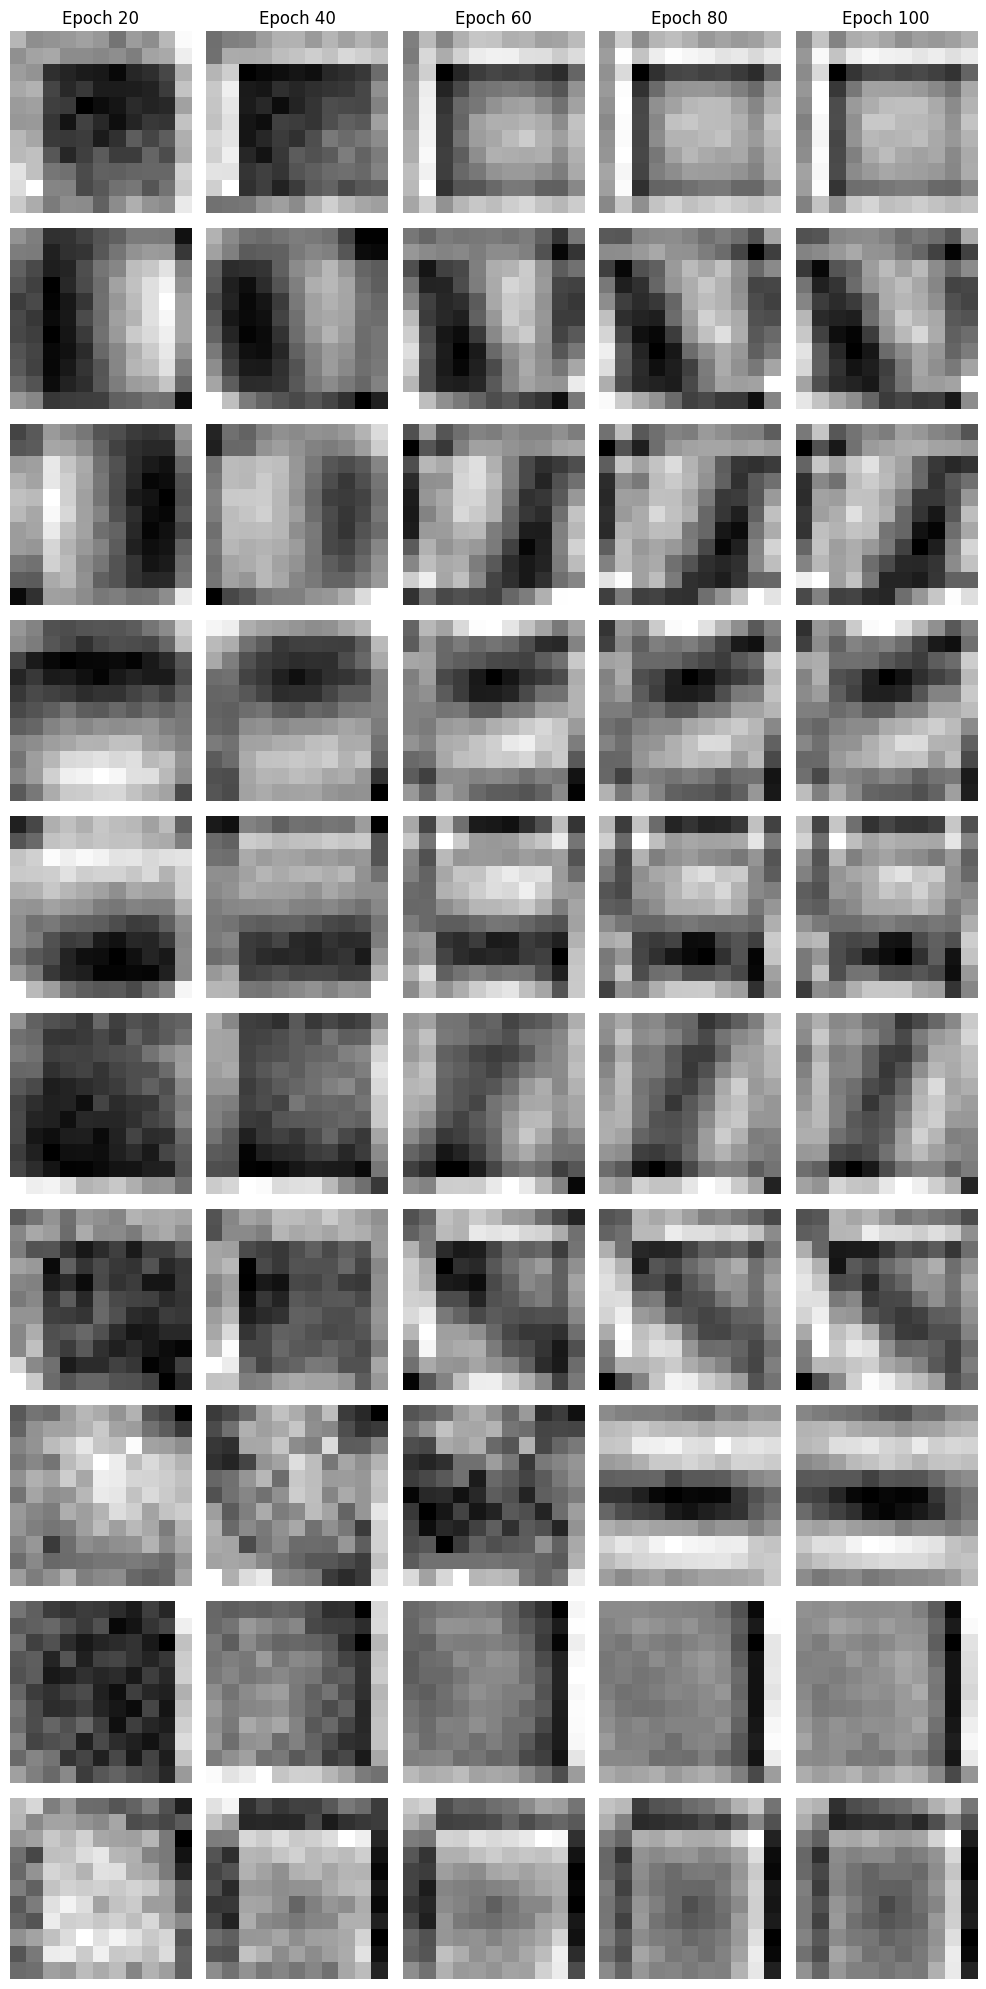

In [8]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_blur"

plot_kernel_evolution(model_dir, 100)


Mean of abs values: 0.4739
Standard deviation: 0.1209


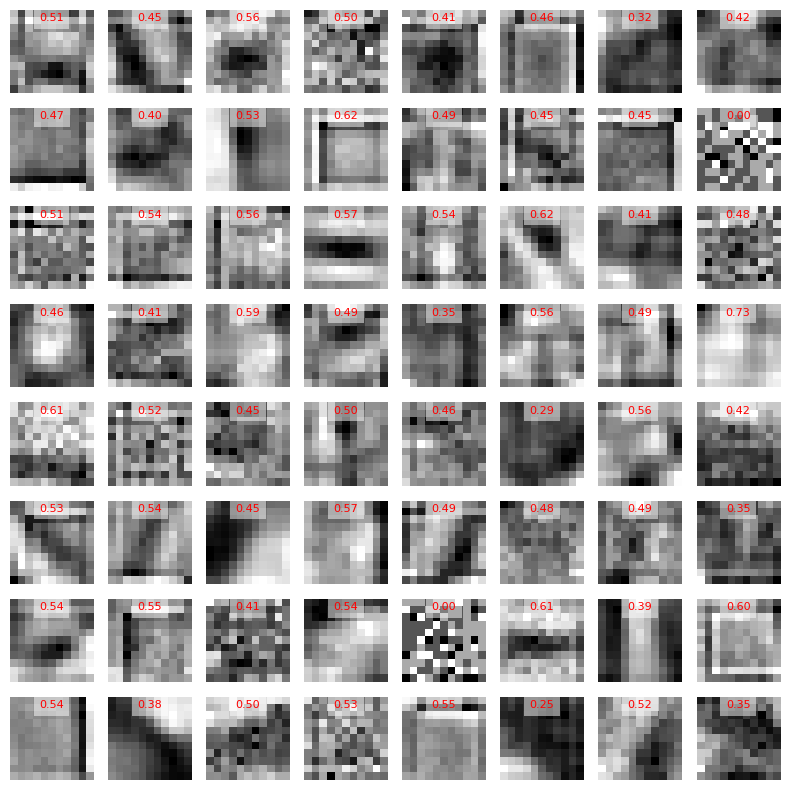

In [19]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_blur"

plot_first_layer_kernels(model_dir, 100)

## Plotting receptive field size

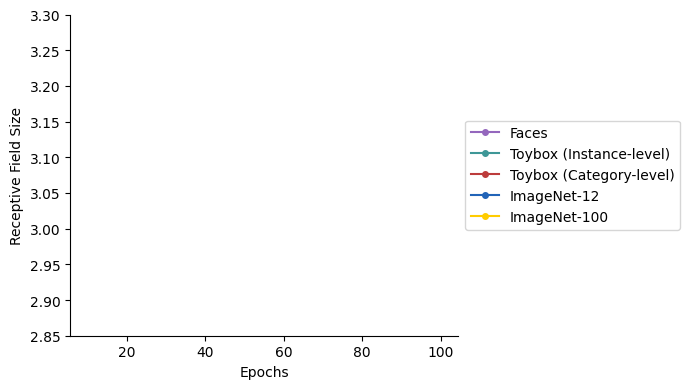

In [11]:
import matplotlib.pyplot as plt

toybox12_rf_evolution = [6.30, 6.31, 6.32, 6.33, 6.33, 6.33, 6.32, 6.32, 6.31, 6.30]
toybox12_rf_evolution_clear = [6.30, 6.25, 6.21, 6.19, 6.16, 6.15, 6.13, 6.11, 6.10, 6.09]
toybox12_rf_evolution_blur = [6.41, 6.39, 6.40, 6.41, 6.41, 6.41, 6.41, 6.41, 6.41, 6.41]

toybox360_rf_evolution = [6.43, 6.41, 6.45, 6.46, 6.50, 6.48, 6.47, 6.47, 6.47, 6.46]
toybox360_rf_evolution_clear = [6.14, 6.18, 6.18, 6.17, 6.18, 6.19, 6.17, 6.17, 6.17, 6.18]
toybox360_rf_evolution_blur = [6.45, 6.41, 6.40, 6.39, 6.39, 6.39, 6.38, 6.38, 6.37, 6.39]

faces_rf_evolution = [6.46, 6.42, 6.47, 6.49, 6.52, 6.53, 6.54, 6.54, 6.54, 6.54]
faces_rf_evolution_clear = [6.39, 6.40, 6.41, 6.42, 6.42, 6.43, 6.42, 6.44, 6.44, 6.44]
faces_rf_evolution_blur = [6.43, 6.39, 6.39, 6.38, 6.38, 6.38, 6.38, 6.38, 6.38, 6.38]

IN12_rf_evolution = [6.47, 6.47, 6.44, 6.43, 6.45, 6.45, 6.46, 6.45, 6.45, 6.45]
IN12_rf_evolution_clear = [6.14, 6.07, 6.02, 6.01, 6.00, 5.99, 5.99, 5.99, 5.99, 5.99]
IN12_rf_evolution_blur = [6.44, 6.43, 6.41, 6.41, 6.41, 6.40, 6.36, 6.36, 6.35, 6.35]

IN100_rf_evolution = [6.39, 6.40, 6.48, 6.50, 6.48, 6.49, 6.50, 6.32, 6.33, 6.31]
IN100_rf_evolution_clear = [5.98, 5.95, 5.97, 5.95, 5.93, 5.91, 5.87, 5.84, 5.81, 5.79]
IN100_rf_evolution_blur = [6.36, 6.35, 6.34, 6.35, 6.34, 6.30, 6.32, 6.32, 6.37, 6.37]

# Define the datasets information.
datasets_info = [
    {"label": "Faces",
     "color": "#9467bd",
     "values": faces_rf_evolution,
     "clear": faces_rf_evolution_clear,
     "blur": faces_rf_evolution_blur},
    {"label": "Toybox (Instance-level)",
     "color": "#3e9797",
     "values": toybox360_rf_evolution,
     "clear": toybox360_rf_evolution_clear,
     "blur": toybox360_rf_evolution_blur},
    {"label": "Toybox (Category-level)",
     "color": "#bc3c3c",
     "values": toybox12_rf_evolution,
     "clear": toybox12_rf_evolution_clear,
     "blur": toybox12_rf_evolution_blur},
    {"label": "ImageNet-12",
     "color": "#2164b8",
     "values": IN12_rf_evolution,
     "clear": IN12_rf_evolution_clear,
     "blur": IN12_rf_evolution_blur},
    {"label": "ImageNet-100",
     "color": "#ffcc00",
     "values": IN100_rf_evolution,
     "clear": IN100_rf_evolution_clear,
     "blur": IN100_rf_evolution_blur},
]

# Define the epochs corresponding to your values.
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Create the plot.
fig, ax = plt.subplots(figsize=(7, 4))

# Loop over each dataset and plot the mean receptive field sizes over epochs.
for ds in datasets_info:
    ax.plot(epochs, ds["values"], marker="o", markersize=4, linestyle="-",
            color=ds["color"], label=ds["label"])

# Customize the plot appearance.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(2.85, 3.3)
ax.set_xlabel("Epochs")
ax.set_ylabel("Receptive Field Size")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

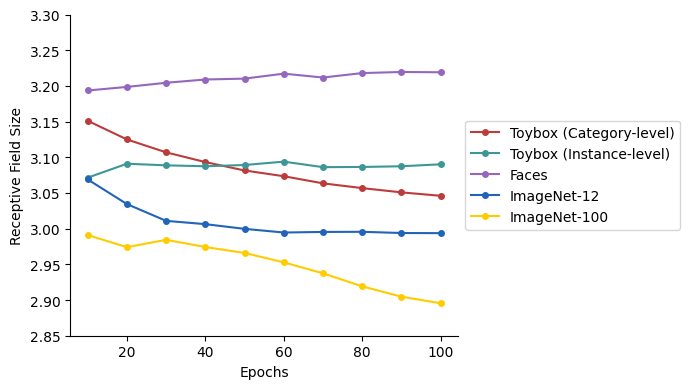

In [ ]:
import matplotlib.pyplot as plt

# Define the datasets information. Each 'values' list should contain the mean receptive field sizes at epochs 20, 40, 60, 80, and 100.
datasets_info = [
    {"label": "Toybox (Category-level)",
     "color": "#bc3c3c",
     "values": toybox12_rf_evolution_clear},
    {"label": "Toybox (Instance-level)",
     "color": "#3e9797",
     "values": toybox360_rf_evolution_clear},
    {"label": "Faces",
     "color": "#9467bd",
     "values": faces_rf_evolution_clear},
    {"label": "ImageNet-12",
     "color": "#2164b8",
     "values": IN12_rf_evolution_clear},
    {"label": "ImageNet-100",
     "color": "#ffcc00",
     "values": IN100_rf_evolution_clear},
]

# Define the epochs corresponding to your values.
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Create the plot.
fig, ax = plt.subplots(figsize=(7, 4))

# Loop over each dataset and plot the mean receptive field sizes over epochs.
for ds in datasets_info:
    ax.plot(epochs, ds["values"], marker="o", markersize=4, linestyle="-",
            color=ds["color"], label=ds["label"])

# Customize the plot appearance.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Epochs")
ax.set_ylim(2.85, 3.3)
ax.set_ylabel("Receptive Field Size")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

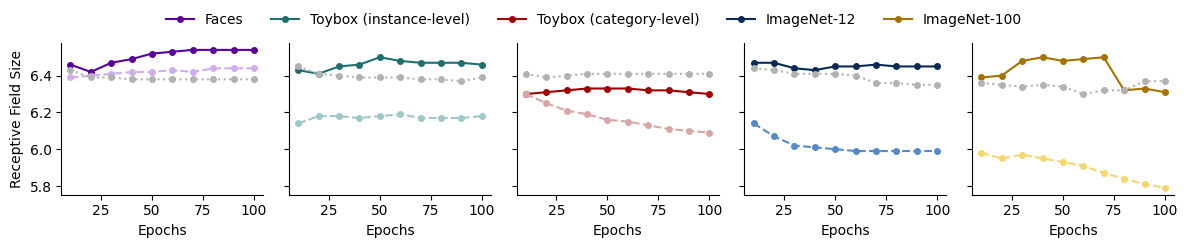

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the datasets information.
# Each dictionary now includes keys for the mean values and the corresponding standard deviations.
datasets_info = [
    {"label": "Faces",
     "dark": "#57039c",
     "light": "#d1adef",
     "values": faces_rf_evolution,
     #"std": faces_rf_std,
     "clear": faces_rf_evolution_clear,
     #"std_clear": faces_rf_std_clear,
     "blur": faces_rf_evolution_blur},
     #"std_blur": faces_rf_std_blur},
    {"label": "Toybox (instance-level)",
     "dark": "#1f6f6f",
     "light": "#9fc8c8",
     "values": toybox360_rf_evolution,
     #"std": toybox360_rf_std,
     "clear": toybox360_rf_evolution_clear,
     #"std_clear": toybox360_rf_std_clear,
     "blur": toybox360_rf_evolution_blur},
     #"std_blur": toybox360_rf_std_blur},
    {"label": "Toybox (category-level)",
     "dark": "#a00000",
     "light": "#d8a6a6",
     "values": toybox12_rf_evolution,
     #"std": toybox12_rf_std,
     "clear": toybox12_rf_evolution_clear,
     #"std_clear": toybox12_rf_std_clear,
     "blur": toybox12_rf_evolution_blur},
     #"std_blur": toybox12_rf_std_blur},
    {"label": "ImageNet-12",
     "dark": "#082a54",
     "light": "#5689c8",
     "values": IN12_rf_evolution,
     #"std": IN12_rf_std,
     "clear": IN12_rf_evolution_clear,
     #"std_clear": IN12_rf_std_clear,
     "blur": IN12_rf_evolution_blur},
     #"std_blur": IN12_rf_std_blur},
    {"label": "ImageNet-100",
     "dark": "#a67300",
     "light": "#f5d76e",
     "values": IN100_rf_evolution,
     #"std": IN100_rf_std,
     "clear": IN100_rf_evolution_clear,
     #"std_clear": IN100_rf_std_clear,
     "blur": IN100_rf_evolution_blur},
     #"std_blur": IN100_rf_std_blur},
]

# Define the epochs corresponding to your values.
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Create a figure with 5 subplots arranged horizontally.
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 2.5), sharey=True)

# Loop over each dataset and its corresponding subplot.
for ax, ds in zip(axes, datasets_info):
    # Plot the dark line (blurry-to-clear) and assign the label.
    ax.plot(epochs, ds["values"], marker="o", markersize=4, linestyle="-",
            color=ds["dark"], label=ds["label"])
    # ax.fill_between(epochs, np.array(ds["values"]) - np.array(ds["std"]),
    #                 p.array(ds["values"]) + np.array(ds["std"]),
    #                 color=ds["dark"], alpha=0.2)
    # Plot the other lines without labels.
    ax.plot(epochs, ds["clear"], marker="o", markersize=4, linestyle="--",
            color=ds["light"])
    # ax.fill_between(epochs, np.array(ds["clear"]) - np.array(ds["std_clear"]),
    #         np.array(ds["clear"]) + np.array(ds["std_clear"]),
    #         color=ds["light"], alpha=0.2)
    ax.plot(epochs, ds["blur"], marker="o", markersize=4, linestyle="dotted",
            color="#b2b2b2")
    # ax.fill_between(epochs,np.array(ds["blur"]) - np.array(ds["std_blur"]),
    #         np.array(ds["blur"]) + np.array(ds["std_blur"]),
    #         color="#c5c5c5", alpha=0.2)

    # Customize the subplot.
    if ax == axes[0]:
        ax.set_ylabel("Receptive Field Size")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Epochs")

# Create one legend for the entire figure using the dark lines.
# We collect the first line from each axis (which corresponds to the dark line).
fig.legend([ax.lines[0] for ax in axes],
           [ds["label"] for ds in datasets_info],
           loc="upper center", ncol=5, frameon=False)

# Adjust the layout so the legend fits nicely at the top.
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

# Receptive field size vs peak spatial frequency preference

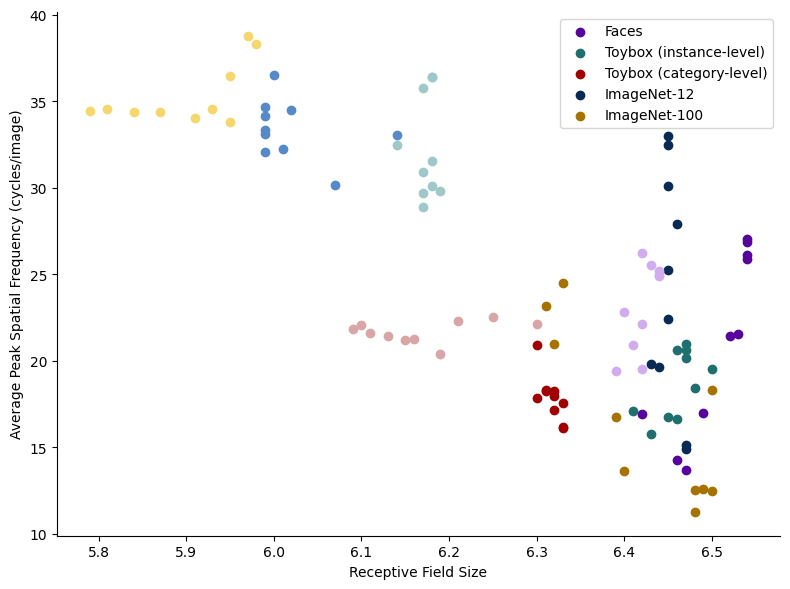

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# ---------------------
# Load spatial frequency data
# ---------------------
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox12_spatial_frequencies.pkl", "rb") as f:
    toybox12_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox360_spatial_frequencies.pkl", "rb") as f:
    toybox360_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/face_spatial_frequencies.pkl", "rb") as f:
    faces_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN12_spatial_frequencies.pkl", "rb") as f:
    IN12_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN100_spatial_frequencies.pkl", "rb") as f:
    IN100_results = pickle.load(f)

with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox12_clear_spatial_frequencies.pkl", "rb") as f:
    toybox12_clear_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox360_clear_spatial_frequencies.pkl", "rb") as f:
    toybox360_clear_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/face_clear_spatial_frequencies.pkl", "rb") as f:
    faces_clear_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN12_clear_spatial_frequencies.pkl", "rb") as f:
    IN12_clear_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN100_clear_spatial_frequencies.pkl", "rb") as f:
    IN100_clear_results = pickle.load(f)

conv1_key = "features.0"
epochs_sf = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Compute the average spatial frequency for each dataset at these epochs.
toybox12_avg_sf = []
toybox360_avg_sf = []
faces_avg_sf = []
IN12_avg_sf = []
IN100_avg_sf = []
toybox12_clear_avg_sf = []
toybox360_clear_avg_sf = []
faces_clear_avg_sf = []
IN12_clear_avg_sf = []
IN100_clear_avg_sf = []

for epoch in epochs_sf:
    data = toybox12_results[epoch].get(conv1_key, [])
    toybox12_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = toybox360_results[epoch].get(conv1_key, [])
    toybox360_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = faces_results[epoch].get(conv1_key, [])
    faces_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = IN12_results[epoch].get(conv1_key, [])
    IN12_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = IN100_results[epoch].get(conv1_key, [])
    IN100_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = toybox12_clear_results[epoch].get(conv1_key, [])
    toybox12_clear_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = toybox360_clear_results[epoch].get(conv1_key, [])
    toybox360_clear_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = faces_clear_results[epoch].get(conv1_key, [])
    faces_clear_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = IN12_clear_results[epoch].get(conv1_key, [])
    IN12_clear_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = IN100_clear_results[epoch].get(conv1_key, [])
    IN100_clear_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)



# ---------------------
# Define colors for each dataset (using the same as in your previous plots)
# ---------------------
colors = {
    'Toybox-12': ("#d8a6a6", "#a00000"),
    'Toybox-360': ("#9fc8c8", "#1f6f6f"),
    'ImageNet-12': ("#5689c8", "#082a54"),
    'FaceScrub': ("#d1adef", "#57039c"),
    'ImageNet-100': ("#f5d76e", "#a67300")
}

# ---------------------
# Plot receptive field size (x-axis) vs. average spatial frequency (y-axis)
# ---------------------
plt.figure(figsize=(8,6))

plt.scatter(faces_rf_evolution, faces_avg_sf, marker='o', color=colors['FaceScrub'][1], label='Faces')
plt.scatter(toybox360_rf_evolution, toybox360_avg_sf, marker='o', color=colors['Toybox-360'][1], label='Toybox (instance-level)')
plt.scatter(toybox12_rf_evolution, toybox12_avg_sf, marker='o', color=colors['Toybox-12'][1], label='Toybox (category-level)')
plt.scatter(IN12_rf_evolution, IN12_avg_sf, marker='o', color=colors['ImageNet-12'][1], label='ImageNet-12')
plt.scatter(IN100_rf_evolution, IN100_avg_sf, marker='o', color=colors['ImageNet-100'][1], label='ImageNet-100')

plt.scatter(faces_rf_evolution_clear, faces_clear_avg_sf, marker='o', color=colors['FaceScrub'][0])
plt.scatter(toybox360_rf_evolution_clear, toybox360_clear_avg_sf, marker='o', color=colors['Toybox-360'][0])
plt.scatter(toybox12_rf_evolution_clear, toybox12_clear_avg_sf, marker='o', color=colors['Toybox-12'][0])
plt.scatter(IN12_rf_evolution_clear, IN12_clear_avg_sf, marker='o', color=colors['ImageNet-12'][0])
plt.scatter(IN100_rf_evolution_clear, IN100_clear_avg_sf, marker='o', color=colors['ImageNet-100'][0])

plt.xlabel("Receptive Field Size")
plt.ylabel("Average Peak Spatial Frequency (cycles/image)")
#plt.title("Conv 1: Receptive Field vs Spatial Frequency Evolution")

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend()
plt.tight_layout()
plt.show()

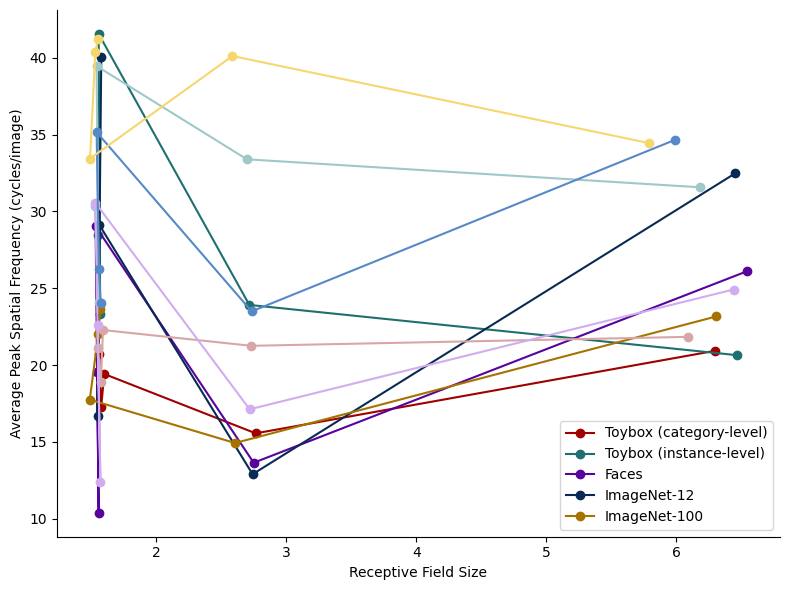

In [ ]:
layers = ["features.0", "features.3", "features.6", "features.8", "features.10"]

toybox12_avg_sf = []
toybox360_avg_sf = []
faces_avg_sf = []
IN12_avg_sf = []
IN100_avg_sf = []
toybox12_clear_avg_sf = []
toybox360_clear_avg_sf = []
faces_clear_avg_sf = []
IN12_clear_avg_sf = []
IN100_clear_avg_sf = []

for layer in layers:
    data = toybox12_results[100].get(layer, [])
    toybox12_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = toybox360_results[100].get(layer, [])
    toybox360_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = faces_results[100].get(layer, [])
    faces_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = IN12_results[100].get(layer, [])
    IN12_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = IN100_results[100].get(layer, [])
    IN100_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = toybox12_clear_results[100].get(layer, [])
    toybox12_clear_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = toybox360_clear_results[100].get(layer, [])
    toybox360_clear_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = faces_clear_results[100].get(layer, [])
    faces_clear_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = IN12_clear_results[100].get(layer, [])
    IN12_clear_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)

    data = IN100_clear_results[100].get(layer, [])
    IN100_clear_avg_sf.append(np.mean(data) if len(data) > 0 else np.nan)


# ---------------------
# Define colors for each dataset (using the same as in your previous plots)
# ---------------------
colors = {
    'Toybox-12': ("#d8a6a6", "#a00000"),
    'Toybox-360': ("#9fc8c8", "#1f6f6f"),
    'ImageNet-12': ("#5689c8", "#082a54"),
    'FaceScrub': ("#d1adef", "#57039c"),
    'ImageNet-100': ("#f5d76e", "#a67300")
}

# ---------------------
# Plot receptive field size (x-axis) vs. average spatial frequency (y-axis)
# ---------------------
plt.figure(figsize=(8,6))

plt.plot(toybox12_rf_layers, toybox12_avg_sf, marker='o', color=colors['Toybox-12'][1], label='Toybox (category-level)')
plt.plot(toybox360_rf_layers, toybox360_avg_sf, marker='o', color=colors['Toybox-360'][1], label='Toybox (instance-level)')
plt.plot(faces_rf_layers, faces_avg_sf,    marker='o', color=colors['FaceScrub'][1],      label='Faces')
plt.plot(IN12_rf_layers, IN12_avg_sf,     marker='o', color=colors['ImageNet-12'][1],  label='ImageNet-12')
plt.plot(IN100_rf_layers, IN100_avg_sf,    marker='o', color=colors['ImageNet-100'][1], label='ImageNet-100')

plt.plot(toybox12_rf_layers_clear, toybox12_clear_avg_sf, marker='o', color=colors['Toybox-12'][0])
plt.plot(toybox360_rf_layers_clear, toybox360_clear_avg_sf, marker='o', color=colors['Toybox-360'][0])
plt.plot(faces_rf_layers_clear, faces_clear_avg_sf,    marker='o', color=colors['FaceScrub'][0])
plt.plot(IN12_rf_layers_clear, IN12_clear_avg_sf,     marker='o', color=colors['ImageNet-12'][0])
plt.plot(IN100_rf_layers_clear, IN100_clear_avg_sf,    marker='o', color=colors['ImageNet-100'][0])

plt.xlabel("Receptive Field Size")
plt.ylabel("Average Peak Spatial Frequency (cycles/image)")
#plt.title("Receptive Field vs Spatial Frequency Across Layers")

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend()
plt.tight_layout()
plt.show()